In [1]:
import os
import utm
import xlrd
import time
import qgrid
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from datetime import datetime
from tqdm.auto import tqdm

sns.set(style="ticks", palette="muted", color_codes=True)

warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20

import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller, ccf
from statsmodels.tsa.seasonal import MSTL

In [2]:
def show_table(df):
    return qgrid.show_grid(df, show_toolbar=True)

In [3]:
#Earlier converted newcrash.xls dataset to csv dataset
file_path = "C:/Users/rogen/Desktop/Omdena/Datasets/"
[file_path + f for f in os.listdir(file_path) if not f.endswith((".zip", ".docx", "dataset", ".xls"))]

['C:/Users/rogen/Desktop/Omdena/Datasets/2021 coordinates.xlsx',
 'C:/Users/rogen/Desktop/Omdena/Datasets/2021Translation.xlsx',
 'C:/Users/rogen/Desktop/Omdena/Datasets/NEWcrash data2.csv']

In [4]:
df1 = pd.read_excel(file_path+"2021Translation.xlsx")
df1.head()

Accident_ID Accident_Type                   Date  Speed  \
0      2331821     Collision  1/30/2021 10:30:00 AM     40   
1      2331821     Collision  1/30/2021 10:30:00 AM     40   
2      2338617     Collision    2021-03-01 18:35:00     60   
3      2338617     Collision    2021-03-01 18:35:00     60   
4      2339228     Collision    2021-05-01 09:13:00     40   

   Number_of_Minor_juries  Number_of_Severe_juries  Number_of_Deaths  \
0                       0                        0                 0   
1                       0                        0                 0   
2                       0                        0                 0   
3                       0                        0                 0   
4                       0                        0                 0   

   Number_of_Moderate_juries                      Road_Lanes  \
0                          0                         one way   
1                          0                         one way   
2                          0  two way without traffic island   
3                          0  two way without traffic island   
4                          0  two way without traffic island   

  Surface_Condition  ... Weather      Road_Characteristic   \
0               dry  ...   Clear  straight, downward slope   
1               dry  ...   Clear  straight, downward slope   
2               dry  ...   Clear           straight, level   
3               dry  ...   Clear           straight, level   
4               dry  ...   Clear           straight, level   

                                      Driver_Mistake      Municipality   \
0       Reversing the vehicle leading to an accident  Ma'an Governorate   
1                                        There is no  Ma'an Governorate   
2  The driver does not leave the safe relay distance  Ma'an Governorate   
3                                        There is no  Ma'an Governorate   
4                                        There is no  Ma'an Governorate   

     Vehicle_Class       Date_of_Accident Number_of_Vehicles  \
0   Small ride car  1/30/2021 10:30:00 AM                  2   
1  Shared transfer  1/30/2021 10:30:00 AM                  2   
2  Shared transfer    2021-03-01 18:35:00                  2   
3   Small ride car    2021-03-01 18:35:00                  2   
4   Small ride car    2021-05-01 09:13:00                  2   

               Name Driver_Age Driver_Gender  
0   crease the gaps       49.0          Male  
1   Salah Rawadiyah       50.0          Male  
2     Amer Salameen       21.0          Male  
3  Walid Al-Tuwaisi       48.0          Male  
4   Ahmed Al-Haloul       32.0          Male  

[5 rows x 24 columns]

In [5]:
#converting dates to pandas datetime format
df1[['Date', 'Date_of_Accident']] = df1[['Date', 'Date_of_Accident']].apply(pd.to_datetime)

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Accident_ID                446 non-null    int64         
 1   Accident_Type              446 non-null    object        
 2   Date                       446 non-null    datetime64[ns]
 3   Speed                      446 non-null    int64         
 4   Number_of_Minor_juries     446 non-null    int64         
 5   Number_of_Severe_juries    446 non-null    int64         
 6   Number_of_Deaths           446 non-null    int64         
 7   Number_of_Moderate_juries  446 non-null    int64         
 8   Road_Lanes                 446 non-null    object        
 9   Surface_Condition          446 non-null    object        
 10  Vehicle_Nationality        446 non-null    object        
 11  Drivg_License_Category     446 non-null    object        
 12  Road_Typ

In [7]:
df1.columns = [col.strip() for col in df1.columns]

In [8]:
for col in df1.select_dtypes(include="object").drop('Name', axis = 1).columns:
    print(col)
    print('*'*len(col))
    print(df1[col].value_counts())
    print()

Accident_Type
*************
Collision    420
Rollover      15
Runover       11
Name: Accident_Type, dtype: int64

Road_Lanes
**********
two way without traffic island    331
two way with traffic island        78
inside a garage                    17
public yards                       13
one way                             7
Name: Road_Lanes, dtype: int64

Surface_Condition
*****************
dry      439
wet        5
snowy      1
icy        1
Name: Surface_Condition, dtype: int64

Vehicle_Nationality
*******************
Jordan          443
Saudi Arabia      1
Bahrain           1
0                 1
Name: Vehicle_Nationality, dtype: int64

Drivg_License_Category
**********************
Third class                    301
Fourth class                    32
Fifth class                     32
Third class automatic           19
0                               16
Unidentified/unknown driver     14
Sixth class (A + B)             10
Sixth category (B)              10
Sixth category (A)          

### Basic Data Cleaning - Reducing the cardinality of category columns

In [9]:
df1['Drivg_License_Category'].value_counts()

Third class                    301
Fourth class                    32
Fifth class                     32
Third class automatic           19
0                               16
Unidentified/unknown driver     14
Sixth class (A + B)             10
Sixth category (B)              10
Sixth category (A)               7
Second Class (A+B)               3
First class                      2
Name: Drivg_License_Category, dtype: int64

In [10]:
#Replace '0' with 'Unidentified/unknown driver'
df1['Drivg_License_Category'] = df1['Drivg_License_Category'].replace('0', 'Unidentified/unknown driver')
df1['Drivg_License_Category'].value_counts()

Third class                    301
Fourth class                    32
Fifth class                     32
Unidentified/unknown driver     30
Third class automatic           19
Sixth class (A + B)             10
Sixth category (B)              10
Sixth category (A)               7
Second Class (A+B)               3
First class                      2
Name: Drivg_License_Category, dtype: int64

In [11]:
len(df1['Driver_Mistake'].unique())

33

In [12]:
np.sort(df1['Driver_Mistake'].unique())

array(['0', 'Do not slow down at school intersections and turns',
       'Driving a vehicle without taking the necessary traffic safety precautions',
       'Driving in the opposite direction, despite the presence of traffic islands',
       'Failure to reduce the speed of the vehicle when passing through populated areas or when approaching schools, pedestrian paths, turns or intersections',
       'Failure to secure vehicle stability while it is parked',
       'Loss of control resulting from skidding or tire explosion leading to an accident',
       'Non-compliance with mandatory requirements',
       'Not securing the stability of the vehicle while it is parked',
       'Opening the vehicle door from the sides or the back while it is in motion',
       'Overtaking a vehicle in a place where overtaking is prohibited',
       'Overtaking at road junctions',
       'Reversing the vehicle leading to an accident',
       'Reversing the vehicle leading to an accident or obstructing traffi

In [13]:
#Replacing sentences that has the same meanong with others.
df1['Driver_Mistake'] = \
df1['Driver_Mistake'].replace(
    ['Not securing the stability of the vehicle while it is parked',
     'Reversing the vehicle leading to an accident',
     'Sudden change of lane',
     'The driver does not leave the safe relay distance',
     'Turning the vehicle in a way that exposes road users to danger',
     'Violations of traffic rules and priorities',
     'Wrong overtaking by the driver of the vehicle in cases where this is prohibited',
     'The driver mishandled turns while driving',
     'Take the wrong lane',
     '0'],
    ['Failure to secure vehicle stability while it is parked',
     'Reversing the vehicle leading to an accident or obstructing traffic',
     'The driver changed lanes abruptly',
     'The driver does not leave the safety relay distance',
     'Turning the vehicle in a way that endangers road users',
     'Violation of traffic rules and priorities',
     'Wrong overtaking in cases and places where overtaking is prohibited',
     'Wrong handling of turns',
     'The driver took the wrong lane',
     'unknown']
)

In [14]:
len(df1['Driver_Mistake'].unique())

24

In [15]:
df1.shape #446 rows

(446, 24)

In [16]:
df1.groupby('Accident_ID').nunique()
#Grouping by Accident_ID, there are total 260 reported accients in this datasets.

Accident_Type  Date  Speed  Number_of_Minor_juries  \
Accident_ID                                                       
2331821                  1     1      1                       1   
2338617                  1     1      1                       1   
2339228                  1     1      1                       1   
2339465                  1     1      1                       1   
2344371                  1     1      1                       1   
...                    ...   ...    ...                     ...   
2545923                  1     1      1                       1   
2545944                  1     1      1                       1   
2546000                  1     1      1                       1   
2546403                  1     1      1                       1   
2546681                  1     1      1                       1   

             Number_of_Severe_juries  Number_of_Deaths  \
Accident_ID                                              
2331821                            1                 1   
2338617                            1                 1   
2339228                            1                 1   
2339465                            1                 1   
2344371                            1                 1   
...                              ...               ...   
2545923                            1                 1   
2545944                            1                 1   
2546000                            1                 1   
2546403                            1                 1   
2546681                            1                 1   

             Number_of_Moderate_juries  Road_Lanes  Surface_Condition  \
Accident_ID                                                             
2331821                              1           1                  1   
2338617                              1           1                  1   
2339228                              1           1                  1   
2339465                              1           1                  1   
2344371                              1           1                  1   
...                                ...         ...                ...   
2545923                              1           1                  1   
2545944                              1           1                  1   
2546000                              1           1                  1   
2546403                              1           1                  1   
2546681                              1           1                  1   

             Vehicle_Nationality  ...  Weather  Road_Characteristic  \
Accident_ID                       ...                                 
2331821                        1  ...        1                    1   
2338617                        1  ...        1                    1   
2339228                        1  ...        1                    1   
2339465                        1  ...        1                    1   
2344371                        1  ...        1                    1   
...                          ...  ...      ...                  ...   
2545923                        1  ...        1                    1   
2545944                        1  ...        1                    1   
2546000                        1  ...        1                    1   
2546403                        1  ...        1                    1   
2546681                        1  ...        1                    1   

             Driver_Mistake  Municipality  Vehicle_Class  Date_of_Accident  \
Accident_ID                                                                  
2331821                   2             1              2                 1   
2338617                   2             1              2                 1   
2339228                   2             1              1                 1   
2339465                   2             1              2                 1   
2344371                   2             1   

In [17]:
df1[['Accident_ID', 'Driver_Mistake']]
#Accident_ID consists of information of the person who caused the accident and the person who got hit.

Accident_ID                                     Driver_Mistake
0        2331821  Reversing the vehicle leading to an accident o...
1        2331821                                        There is no
2        2338617  The driver does not leave the safety relay dis...
3        2338617                                        There is no
4        2339228                                        There is no
..           ...                                                ...
441      2546000                            Wrong handling of turns
442      2546403                                        There is no
443      2546403          Violation of traffic rules and priorities
444      2546681  Failure to secure vehicle stability while it i...
445      2546681                                        There is no

[446 rows x 2 columns]

# 2021 Coordinates dataset

In [18]:
df2 = pd.read_excel(file_path+'2021 coordinates.xlsx').drop('Unnamed: 0', axis=1)

In [19]:
#Filing null values in this columns with 0
df2['rollover'] = df2['rollover'].fillna(0)

In [20]:
df2.shape

(260, 14)

In [21]:
df2.groupby('Accident_ID').nunique()
#All unique rows

Accident_SerialNo  Accident_Date  Longitude  latitude  minor  \
Accident_ID                                                                 
2331821                      1              1          1         1      1   
2338617                      1              1          1         1      1   
2339228                      1              1          1         1      1   
2339465                      1              1          1         1      1   
2344371                      1              1          1         1      1   
...                        ...            ...        ...       ...    ...   
2545923                      1              1          1         1      1   
2545944                      1              1          1         1      1   
2546000                      1              1          1         1      1   
2546403                      1              1          1         1      1   
2546681                      1              1          1         1      1   

             major  moderate  death  materials  humans  collision  runover  \
Accident_ID                                                                  
2331821          1         1      1          1       1          1        1   
2338617          1         1      1          1       1          1        1   
2339228          1         1      1          1       1          1        1   
2339465          1         1      1          1       1          1        1   
2344371          1         1      1          1       1          1        1   
...            ...       ...    ...        ...     ...        ...      ...   
2545923          1         1      1          1       1          1        1   
2545944          1         1      1          1       1          1        1   
2546000          1         1      1          1       1          1        1   
2546403          1         1      1          1       1          1        1   
2546681          1         1      1          1       1          1        1   

             rollover  
Accident_ID            
2331821             1  
2338617             1  
2339228             1  
2339465             1  
2344371             1  
...               ...  
2545923             1  
2545944             1  
2546000             1  
2546403             1  
2546681             1  

[260 rows x 13 columns]

Since the the accident_ID of this dataset matches with df1, i will join these 2 datasets together.

In [22]:
df_merged = df1.merge(df2, how='left', on='Accident_ID')

In [23]:
df_merged

Accident_ID Accident_Type                Date  Speed  \
0        2331821     Collision 2021-01-30 10:30:00     40   
1        2331821     Collision 2021-01-30 10:30:00     40   
2        2338617     Collision 2021-03-01 18:35:00     60   
3        2338617     Collision 2021-03-01 18:35:00     60   
4        2339228     Collision 2021-05-01 09:13:00     40   
..           ...           ...                 ...    ...   
441      2546000     Collision 2021-12-28 14:16:00     70   
442      2546403     Collision 2021-12-29 10:56:00     40   
443      2546403     Collision 2021-12-29 10:56:00     40   
444      2546681     Collision 2021-12-29 17:45:00     50   
445      2546681     Collision 2021-12-29 17:45:00     50   

     Number_of_Minor_juries  Number_of_Severe_juries  Number_of_Deaths  \
0                         0                        0                 0   
1                         0                        0                 0   
2                         0                        0                 0   
3                         0                        0                 0   
4                         0                        0                 0   
..                      ...                      ...               ...   
441                       0                        0                 0   
442                       0                        0                 0   
443                       0                        0                 0   
444                       0                        0                 0   
445                       0                        0                 0   

     Number_of_Moderate_juries                      Road_Lanes  \
0                            0                         one way   
1                            0                         one way   
2                            0  two way without traffic island   
3                            0  two way without traffic island   
4                            0  two way without traffic island   
..                         ...                             ...   
441                          0  two way without traffic island   
442                          0  two way without traffic island   
443                          0  two way without traffic island   
444                          0                         one way   
445                          0                         one way   

    Surface_Condition  ... latitude minor major moderate death materials  \
0                 dry  ...  3356370     0     0        0     0         1   
1                 dry  ...  3356370     0     0        0     0         1   
2                 dry  ...  3356248     0     0        0     0         1   
3                 dry  ...  3356248     0     0        0     0         1   
4                 dry  ...  3356463     0     0        0     0         1   
..                ...  ...      ...   ...   ...      ...   ...       ...   
441               dry  ...  3356518     0     0        0     0         1   
442               dry  ...  3403109     0     0        0     0         1   
443               dry  ...  3403109     0     0        0     0         1   
444               dry  ...  3399310     0     0        0     0         1   
445               dry  ...  3399310     0     0        0     0         1   

    humans collision runover rollover  
0        0         1       0      0.0  
1        0         1       0      0.0  
2        0         1       0      0.0  
3        0         1       0      0.0  
4        0         1       0      0.0  
..     ...       ...     ...      ...  
441      0         1       0      0.0  
442      0         1       0      0.0  
443      0         1       0      0.0  
444      0         1       0      0.0  
445      0         1       0      0.0  

[446 rows x 37 columns]

In [24]:
print(any(df_merged['Date']!=df_merged['Accident_Date']))

False


In [25]:
print(any(df_merged['Date']!=df_merged['Date_of_Accident']))

False


In [26]:
print(any(df_merged['Accident_Date']!=df_merged['Date_of_Accident']))

False


In [27]:
df_merged.columns

Index(['Accident_ID', 'Accident_Type', 'Date', 'Speed',
       'Number_of_Minor_juries', 'Number_of_Severe_juries', 'Number_of_Deaths',
       'Number_of_Moderate_juries', 'Road_Lanes', 'Surface_Condition',
       'Vehicle_Nationality', 'Drivg_License_Category', 'Road_Type',
       'Lighting', 'Weather', 'Road_Characteristic', 'Driver_Mistake',
       'Municipality', 'Vehicle_Class', 'Date_of_Accident',
       'Number_of_Vehicles', 'Name', 'Driver_Age', 'Driver_Gender',
       'Accident_SerialNo', 'Accident_Date', 'Longitude', 'latitude', 'minor',
       'major', 'moderate', 'death', 'materials', 'humans', 'collision',
       'runover', 'rollover'],
      dtype='object')

In [28]:
#dropping same info columns
df_merged = df_merged.drop(['Date', 'Date_of_Accident'], axis = 1)

In [29]:
#3 columns have null values
df_merged.isnull().sum()[df_merged.isnull().sum()>0]

Name              3
Driver_Age       14
Driver_Gender     8
dtype: int64

In [30]:
#No duplicates
df_merged.duplicated().sum()

0

In [31]:
df_merged.loc[df_merged['Driver_Gender'].isnull(), ['Name', 'Driver_Gender']]

Name Driver_Gender
203      Samson Emma           NaN
278              NaN           NaN
320  Patrick De Witt           NaN
324      Markus Post           NaN
366   Mounia Mekaoui           NaN
386  Melissa Amroush           NaN
389              NaN           NaN
414              NaN           NaN

In [32]:
df_merged.loc[
    df_merged['Driver_Gender'].isnull() &
    df_merged['Name'].isin(['Samson Emma', 'Mounia Mekaoui', 'Melissa Amroush']), 
    'Driver_Gender'
] = 'Female'

In [33]:
df_merged['Driver_Gender'] = df_merged['Driver_Gender'].fillna('Male')

In [34]:
df_merged['Driver_Gender'].isna().sum()

0

In [35]:
df_merged.isnull().sum()[df_merged.isnull().sum()>0]

Name           3
Driver_Age    14
dtype: int64

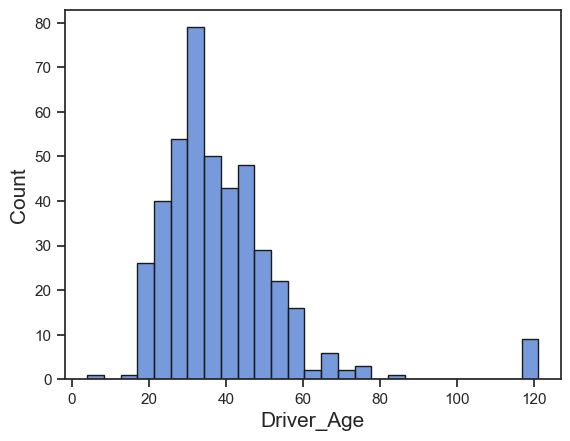

In [36]:
sns.histplot(df_merged['Driver_Age'], edgecolor='k');

In [37]:
df_merged['Driver_Age'].describe()

count    432.000000
mean      38.902778
std       16.811906
min        4.000000
25%       28.000000
50%       36.000000
75%       45.000000
max      121.000000
Name: Driver_Age, dtype: float64

In [38]:
df_merged.loc[
    df_merged['Driver_Age'].ge(70) | df_merged['Driver_Age'].lt(18),
    ['Name', 'Driver_Age', 'Driver_Gender', 'Driver_Mistake']
].sort_values('Driver_Age')

Name  Driver_Age Driver_Gender  \
295         Ahmed Al-Nasrat         4.0          Male   
139  Abdul Rahman Al-Awadat        16.0          Male   
34            Salem fertile        71.0          Male   
204      Ahmed Al-Khawaldeh        73.0          Male   
115       Mustafa Al-Qara’a        74.0          Male   
164       Mohammed Al-Toura        75.0          Male   
62       stead of Shuqairat        77.0          Male   
234       Ahmad Al Khashman        82.0          Male   
120           Suhaib Shabat       121.0          Male   
64           Now Al-Sawalqa       121.0          Male   
386         Melissa Amroush       121.0        Female   
233      Abdullah Al-Zaidan       121.0          Male   
252         Ahmad Al-Turman       121.0          Male   
320         Patrick De Witt       121.0          Male   
376    Mujahid Al-Masaedeen       121.0          Male   
65      Who are the Omaris?       121.0          Male   
444         Mamdouh Al-Jazi       121.0          Male   

                                        Driver_Mistake  
295          Violation of traffic rules and priorities  
139                                        There is no  
34                                         There is no  
204                                        There is no  
115  Reversing the vehicle leading to an accident o...  
164                                        There is no  
62   Driving a vehicle without taking the necessary...  
234          Violation of traffic rules and priorities  
120                                        There is no  
64   The driver does not leave the safety relay dis...  
386  Do not slow down at school intersections and t...  
233                  The driver changed lanes abruptly  
252  Driving a vehicle without taking the necessary...  
320                                        There is no  
376                                        There is no  
65                                         There is no  
444  Failure to secure vehicle stability while it i...

In [39]:
#replacing ages 4 and 121 with null, then impute missing values with the median age
df_merged.loc[
    df_merged['Driver_Age'].ge(100) | df_merged['Driver_Age'].lt(16), 'Driver_Age'
] = np.nan

In [40]:
df_merged['Driver_Age'] = df_merged['Driver_Age'].fillna(df_merged['Driver_Age'].median())

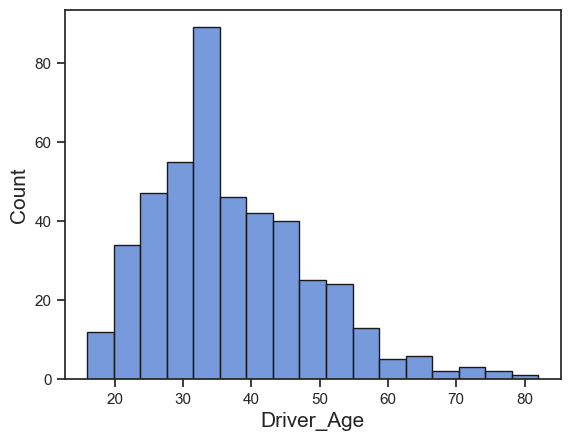

In [41]:
sns.histplot(df_merged['Driver_Age'], edgecolor='k');

In [42]:
#These columns are not important
df_merged = df_merged.drop(['Name', 'Vehicle_Nationality'], axis = 1)

In [43]:
df_merged.columns

Index(['Accident_ID', 'Accident_Type', 'Speed', 'Number_of_Minor_juries',
       'Number_of_Severe_juries', 'Number_of_Deaths',
       'Number_of_Moderate_juries', 'Road_Lanes', 'Surface_Condition',
       'Drivg_License_Category', 'Road_Type', 'Lighting', 'Weather',
       'Road_Characteristic', 'Driver_Mistake', 'Municipality',
       'Vehicle_Class', 'Number_of_Vehicles', 'Driver_Age', 'Driver_Gender',
       'Accident_SerialNo', 'Accident_Date', 'Longitude', 'latitude', 'minor',
       'major', 'moderate', 'death', 'materials', 'humans', 'collision',
       'runover', 'rollover'],
      dtype='object')

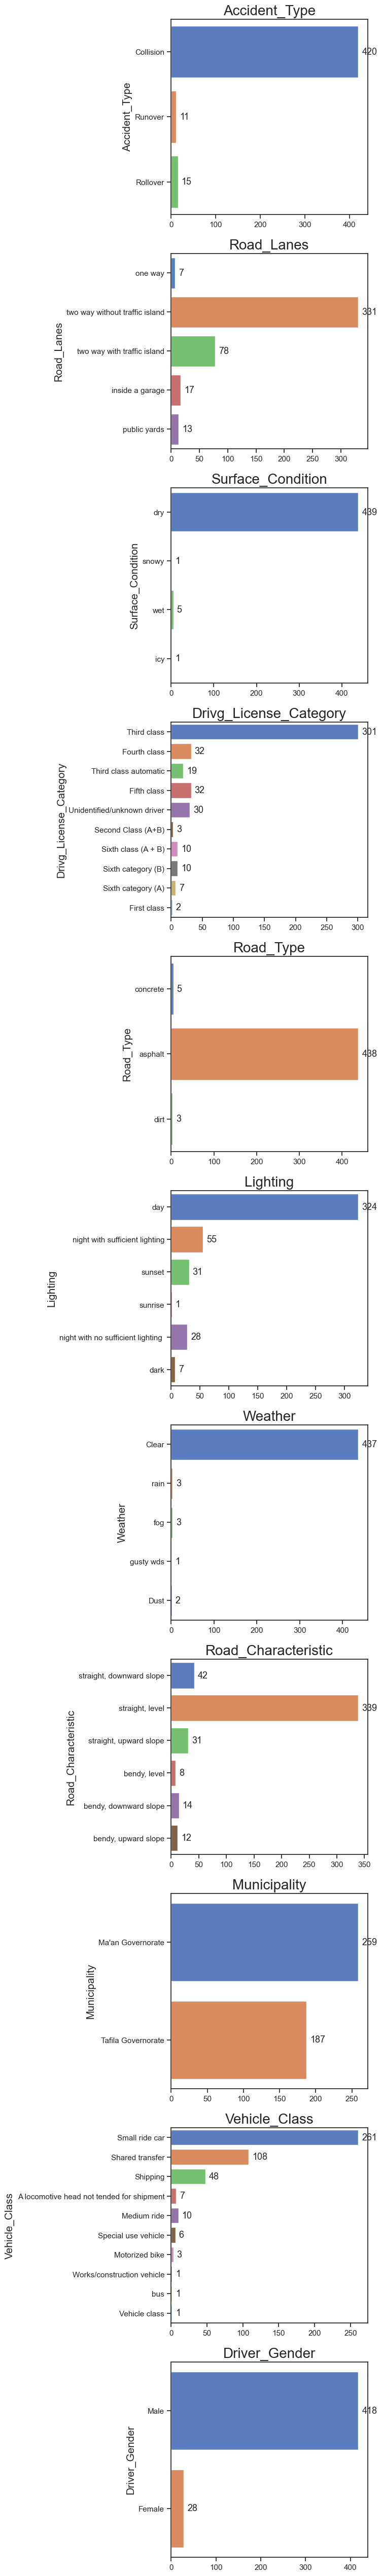

In [44]:
#plotting categorical columns
cat_cols = [
    'Accident_Type', 'Road_Lanes', 'Surface_Condition', 'Drivg_License_Category', 'Road_Type', 
    'Lighting', 'Weather', 'Road_Characteristic', 'Municipality', 
    'Vehicle_Class', 'Driver_Gender'
]

fig, axes = plt.subplots(11, 1, figsize = (5, 65))

for col, ax in zip(cat_cols, axes.flatten()):
    
    sns.countplot(y=df_merged[col], ax = ax)
    ax.bar_label(ax.containers[0], fontsize = 13, padding = 5);
    
    ax.set_title(col)
    ax.set_xlabel('')

In [45]:
#Creating new columns where accidents did not end up in any injuries
injuries = \
df_merged[[
    'Number_of_Minor_juries', 'Number_of_Severe_juries', 'Number_of_Deaths', 
    'Number_of_Moderate_juries'
]].sum(axis = 1)

df_merged['Number_of_No_Injuries'] = np.where(injuries!=0, 0, 1)

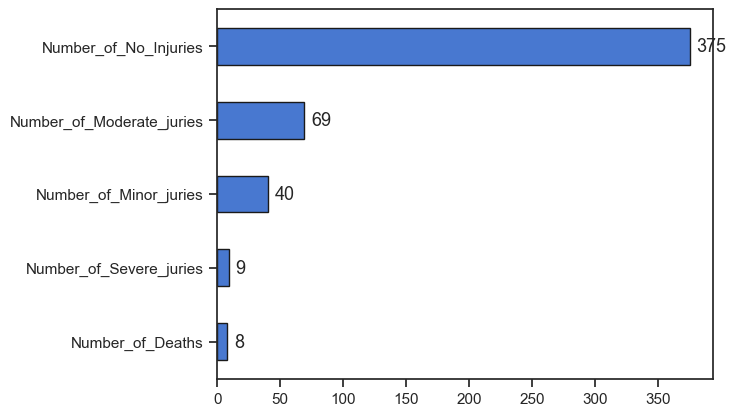

In [46]:
ax = df_merged[[
    'Number_of_Minor_juries', 'Number_of_Severe_juries', 'Number_of_Deaths', 
    'Number_of_Moderate_juries', 'Number_of_No_Injuries'
]].sum().sort_values().plot(kind = 'barh', edgecolor='k');

ax.bar_label(ax.containers[0], fontsize = 13, padding = 5);

In [47]:
#Converting coordinates from UTM to lat/long
def utm_to_latlon(df, zone_number, zone_letter):
    easting = df['Longitude']
    northing = df['latitude']
    
    lat = utm.to_latlon(easting, northing, zone_number, zone_letter)[0]
    long = utm.to_latlon(easting, northing, zone_number, zone_letter)[1]
    
    return lat, long


df_merged['lat'], df_merged['long'] = utm_to_latlon(df=df_merged, zone_number=36, zone_letter='R')

In [48]:
df_merged = df_merged.drop(['Longitude', 'latitude'], axis = 1)

#### Extract data and time features

In [49]:
df_merged['year'] = df_merged['Accident_Date'].dt.year
df_merged['month'] = df_merged['Accident_Date'].dt.month
df_merged['day'] = df_merged['Accident_Date'].dt.day
df_merged['dayofweek'] = df_merged['Accident_Date'].dt.dayofweek
df_merged['hour'] = df_merged['Accident_Date'].dt.hour

In [50]:
for col in ['year', 'month', 'day', 'dayofweek', 'hour']:
    print(col)
    print('*'*len(col))
    print(df_merged[col].value_counts().sort_index())
    print()

year
****
2021    446
Name: year, dtype: int64

month
*****
1     30
2     27
3     42
4     27
5     59
6     24
7     38
8     16
9     33
10    45
11    51
12    54
Name: month, dtype: int64

day
***
1      9
2     13
3     12
4      6
5     12
6      8
7     15
8     15
9      9
10    16
11     9
12    22
13    21
14    21
15    11
16    10
17    25
18     6
19    15
20    11
21    19
22    26
23    16
24    12
25    11
26    17
27    19
28    19
29    16
30    14
31    11
Name: day, dtype: int64

dayofweek
*********
0    58
1    89
2    63
3    69
4    47
5    60
6    60
Name: dayofweek, dtype: int64

hour
****
0      4
1      2
2      2
3      2
4      1
5      2
6      1
7      2
8     15
9     33
10    15
11    30
12    27
13    25
14    50
15    51
16    37
17    36
18    40
19    21
20    16
21    15
22    10
23     9
Name: hour, dtype: int64



In [51]:
df_merged['Accident_Date_only'] = pd.to_datetime(df_merged['Accident_Date'].dt.date)

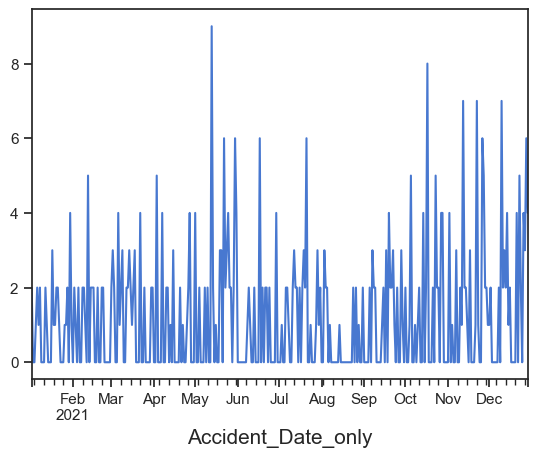

In [52]:
df_merged.set_index('Accident_Date_only').resample('D').size().plot();

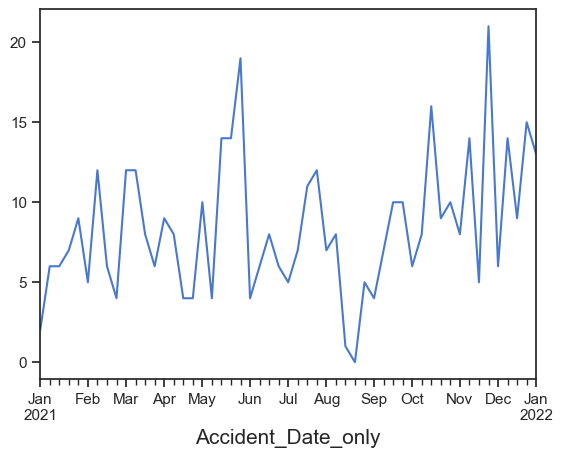

In [53]:
df_merged.set_index('Accident_Date_only').resample('W').size().plot();

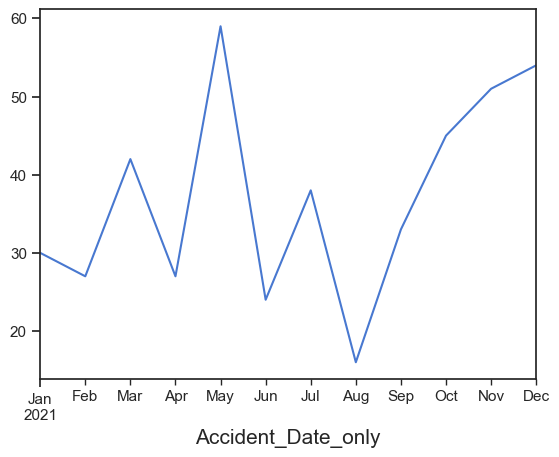

In [54]:
df_merged.set_index('Accident_Date_only').resample('M').size().plot();

The 2021 dataset is too small and has days where there are no accidents, which is impossible unless the data is from a region with significantly less population. Hence, I will stop the EDA here for 2021 and move on with the next dataset.

# NEWcrash data2.csv

In [55]:
df3 = pd.read_csv(file_path+'NEWcrash data2.csv')

In [56]:
df3['Year'].unique()

array([2014, 2015, 2016, 2017, 2018], dtype=int64)

In [57]:
df3.duplicated().sum()

1156

In [58]:
df3 = df3.drop_duplicates(ignore_index=True)

In [59]:
#cleaning columns names
df3.columns = [col.strip() for col in df3.columns]

In [60]:
df3.isna().sum()

Accident_ID              0
street                   0
Accident_SerialNo        0
Accident_Date            0
Year                     0
Month                    0
Day                      0
Date                     0
Time                     0
Longitude                0
latitude                 0
C                        0
A                        1
B                        0
K                        0
O                        0
On_Peop                  0
Crash                    0
Pedes                    0
Run_Off              64171
dtype: int64

In [61]:
df3['Run_Off'] = df3['Run_Off'].fillna(0)

In [62]:
df3['A'] = df3['A'].fillna(0)

In [63]:
#convertinf microsoft excel dates to proper datetime format
df3['Accident_Date'] = df3['Accident_Date'].apply(lambda s: xlrd.xldate.xldate_as_datetime(s, 0))
df3['Date'] = df3['Date'].apply(lambda s: xlrd.xldate.xldate_as_datetime(s, 0))

In [64]:
df3 = df3.sort_values('Accident_Date', ignore_index=True)

In [65]:
#Converting coordinates from UTM to lat/long
df3['lat'], df3['long'] = utm_to_latlon(df=df3, zone_number=36, zone_letter='R')

In [66]:
df3 = df3.drop(['street', 'Time', 'Longitude', 'latitude'], axis = 1)

In [67]:
#extracting features from datetime
df3['Day'] = df3['Accident_Date'].dt.day
df3['dayofweek'] = df3['Accident_Date'].dt.dayofweek
df3['hour'] = df3['Accident_Date'].dt.hour
df3['week'] = df3['Accident_Date'].dt.isocalendar().week
df3['Time'] = df3['Accident_Date'].dt.time

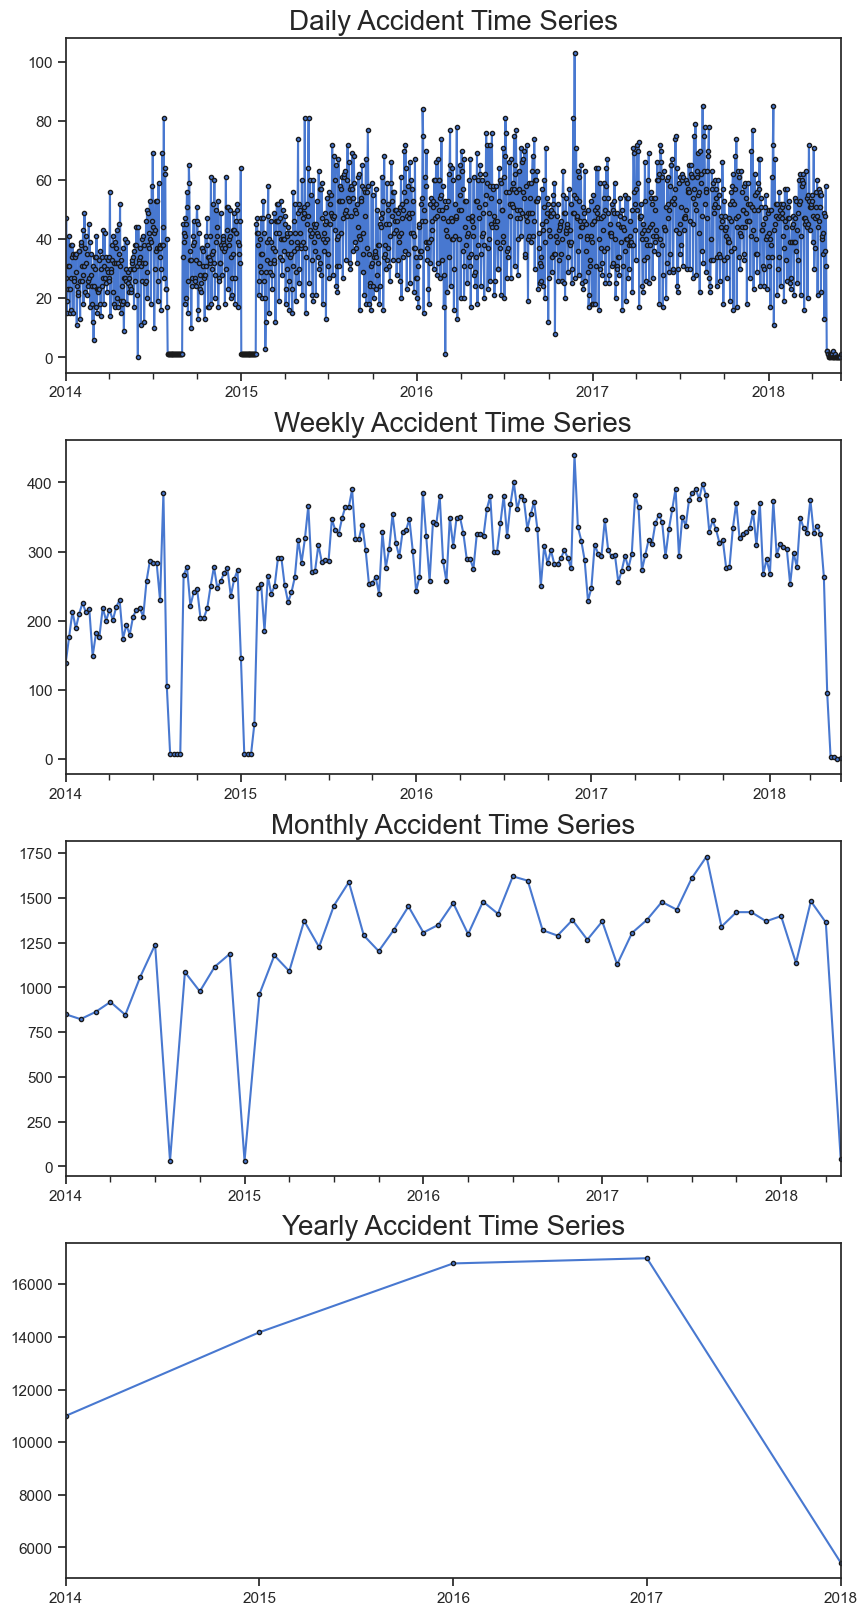

In [68]:
fig, axes = plt.subplots(4, 1, figsize=(10, 20))

for time_group, title, ax in zip(['D', 'W', 'M', 'Y'], 
                                 ['Daily', 'Weekly', 'Monthly', 'Yearly'], 
                                 axes.flatten()):
    
    df3.set_index('Date').resample(time_group)['Accident_ID'].nunique().\
        plot(ax=ax, marker='.', mec='k')
    
    ax.set_xlabel('')
    ax.set_title(f'{title} Accident Time Series');

during specific months, the number of accidents are unusually low. This is something we need to ask about on the future.

In [69]:
daily_acc_ts = \
df3.set_index('Date').resample('D')['Accident_ID'].nunique()

daily_acc_ts.loc[(daily_acc_ts.index > '2014-07-28') & (daily_acc_ts.index < '2014-09-05')]
#According to the data, the whole month of Aug 2014 has just 1 accident. 

Date
2014-07-29    23
2014-07-30    40
2014-07-31    17
2014-08-01     1
2014-08-02     1
2014-08-03     1
2014-08-04     1
2014-08-05     1
2014-08-06     1
2014-08-07     1
2014-08-08     1
2014-08-09     1
2014-08-10     1
2014-08-11     1
2014-08-12     1
2014-08-13     1
2014-08-14     1
2014-08-15     1
2014-08-16     1
2014-08-17     1
2014-08-18     1
2014-08-19     1
2014-08-20     1
2014-08-21     1
2014-08-22     1
2014-08-23     1
2014-08-24     1
2014-08-25     1
2014-08-26     1
2014-08-27     1
2014-08-28     1
2014-08-29     1
2014-08-30     1
2014-08-31     1
2014-09-01    34
2014-09-02    45
2014-09-03    42
2014-09-04    39
Freq: D, Name: Accident_ID, dtype: int64

In [70]:
daily_acc_ts.loc[(daily_acc_ts.index > '2014-12-28') & (daily_acc_ts.index < '2015-02-05')]
#Same for May 2015 

Date
2014-12-29    32
2014-12-30    46
2014-12-31    64
2015-01-01     1
2015-01-02     1
2015-01-03     1
2015-01-04     1
2015-01-05     1
2015-01-06     1
2015-01-07     1
2015-01-08     1
2015-01-09     1
2015-01-10     1
2015-01-11     1
2015-01-12     1
2015-01-13     1
2015-01-14     1
2015-01-15     1
2015-01-16     1
2015-01-17     1
2015-01-18     1
2015-01-19     1
2015-01-20     1
2015-01-21     1
2015-01-22     1
2015-01-23     1
2015-01-24     1
2015-01-25     1
2015-01-26     1
2015-01-27     1
2015-01-28     1
2015-01-29     1
2015-01-30     1
2015-01-31     1
2015-02-01    45
2015-02-02    42
2015-02-03    47
2015-02-04    38
Freq: D, Name: Accident_ID, dtype: int64

In [71]:
daily_acc_ts.loc[(daily_acc_ts.index > '2018-04-28')]
#Finally same for May 2018

Date
2018-04-29    48
2018-04-30    58
2018-05-01    31
2018-05-02     2
2018-05-03     2
2018-05-04     1
2018-05-05     1
2018-05-06     0
2018-05-07     0
2018-05-08     1
2018-05-09     0
2018-05-10     1
2018-05-11     0
2018-05-12     0
2018-05-13     1
2018-05-14     0
2018-05-15     0
2018-05-16     2
2018-05-17     0
2018-05-18     0
2018-05-19     0
2018-05-20     1
2018-05-21     0
2018-05-22     0
2018-05-23     0
2018-05-24     0
2018-05-25     0
2018-05-26     0
2018-05-27     0
2018-05-28     0
2018-05-29     0
2018-05-30     0
2018-05-31     1
Freq: D, Name: Accident_ID, dtype: int64

In [72]:
df3.loc[
    df3['Year'].eq(2014) & df3['Month'].eq(8),
    ['Accident_ID', 'Accident_Date', 'Date', 'Time']
].sort_values('Accident_Date', ignore_index=True)

Accident_ID           Accident_Date       Date             Time
0       1015722 2014-08-01 19:23:00.000 2014-08-01         19:23:00
1       1022693 2014-08-02 19:22:59.995 2014-08-02  19:22:59.995000
2       1023387 2014-08-03 19:22:59.995 2014-08-03  19:22:59.995000
3       1024065 2014-08-04 19:22:59.995 2014-08-04  19:22:59.995000
4       1024151 2014-08-05 19:22:59.995 2014-08-05  19:22:59.995000
5       1024152 2014-08-06 19:22:59.995 2014-08-06  19:22:59.995000
6       1024155 2014-08-07 19:22:59.995 2014-08-07  19:22:59.995000
7       1024272 2014-08-08 19:22:59.995 2014-08-08  19:22:59.995000
8       1024319 2014-08-09 19:22:59.995 2014-08-09  19:22:59.995000
9       1024323 2014-08-10 19:22:59.995 2014-08-10  19:22:59.995000
10      1024325 2014-08-11 19:22:59.995 2014-08-11  19:22:59.995000
11      1024326 2014-08-12 19:22:59.995 2014-08-12  19:22:59.995000
12      1024327 2014-08-13 19:22:59.995 2014-08-13  19:22:59.995000
13      1024329 2014-08-14 19:22:59.995 2014-08-14  19:22:59.995000
14      1024331 2014-08-15 19:22:59.995 2014-08-15  19:22:59.995000
15      1024332 2014-08-16 19:22:59.995 2014-08-16  19:22:59.995000
16      1024333 2014-08-17 19:22:59.995 2014-08-17  19:22:59.995000
17      1024335 2014-08-18 19:22:59.995 2014-08-18  19:22:59.995000
18      1024336 2014-08-19 19:22:59.995 2014-08-19  19:22:59.995000
19      1024337 2014-08-20 19:22:59.995 2014-08-20  19:22:59.995000
20      1024368 2014-08-21 19:22:59.995 2014-08-21  19:22:59.995000
21      1024473 2014-08-22 19:22:59.995 2014-08-22  19:22:59.995000
22      1024477 2014-08-23 19:22:59.995 2014-08-23  19:22:59.995000
23      1024480 2014-08-24 19:22:59.995 2014-08-24  19:22:59.995000
24      1024484 2014-08-25 19:22:59.995 2014-08-25  19:22:59.995000
25      1024494 2014-08-26 19:22:59.995 2014-08-26  19:22:59.995000
26      1024498 2014-08-27 19:22:59.995 2014-08-27  19:22:59.995000
27      1024513 2014-08-28 19:22:59.995 2014-08-28  19:22:59.995000
28      1024514 2014-08-29 19:22:59.995 2014-08-29  19:22:59.995000
29      1024518 2014-08-30 19:22:59.995 2014-08-30  19:22:59.995000
30      1024532 2014-08-31 19:22:59.995 2014-08-31  19:22:59.995000

In [73]:
df3.loc[
    df3['Year'].eq(2015) & df3['Month'].eq(1),
    ['Accident_ID', 'Accident_Date', 'Date', 'Time']
].sort_values('Accident_Date', ignore_index=True)

Accident_ID           Accident_Date       Date             Time
0       1028065 2015-01-01 19:22:59.995 2015-01-01  19:22:59.995000
1       1028070 2015-01-02 19:22:59.995 2015-01-02  19:22:59.995000
2       1028074 2015-01-03 19:22:59.995 2015-01-03  19:22:59.995000
3       1028077 2015-01-04 19:22:59.995 2015-01-04  19:22:59.995000
4       1028092 2015-01-05 19:22:59.995 2015-01-05  19:22:59.995000
5       1028102 2015-01-06 19:22:59.995 2015-01-06  19:22:59.995000
6       1028116 2015-01-07 19:22:59.995 2015-01-07  19:22:59.995000
7       1028125 2015-01-08 19:22:59.995 2015-01-08  19:22:59.995000
8       1028141 2015-01-09 19:22:59.995 2015-01-09  19:22:59.995000
9       1028158 2015-01-10 19:22:59.995 2015-01-10  19:22:59.995000
10      1028160 2015-01-11 19:22:59.995 2015-01-11  19:22:59.995000
11      1028164 2015-01-12 19:22:59.995 2015-01-12  19:22:59.995000
12      1028168 2015-01-13 19:22:59.995 2015-01-13  19:22:59.995000
13      1028171 2015-01-14 19:22:59.995 2015-01-14  19:22:59.995000
14      1028177 2015-01-15 19:22:59.995 2015-01-15  19:22:59.995000
15      1028214 2015-01-16 19:22:59.995 2015-01-16  19:22:59.995000
16      1028219 2015-01-17 19:22:59.995 2015-01-17  19:22:59.995000
17      1028280 2015-01-18 19:22:59.995 2015-01-18  19:22:59.995000
18      1028301 2015-01-19 19:22:59.995 2015-01-19  19:22:59.995000
19      1028371 2015-01-20 19:22:59.995 2015-01-20  19:22:59.995000
20      1028394 2015-01-21 19:22:59.995 2015-01-21  19:22:59.995000
21      1028403 2015-01-22 19:22:59.995 2015-01-22  19:22:59.995000
22      1028412 2015-01-23 19:22:59.995 2015-01-23  19:22:59.995000
23      1028423 2015-01-24 19:22:59.995 2015-01-24  19:22:59.995000
24      1028424 2015-01-25 19:22:59.995 2015-01-25  19:22:59.995000
25      1028427 2015-01-26 19:22:59.995 2015-01-26  19:22:59.995000
26      1028431 2015-01-27 19:22:59.995 2015-01-27  19:22:59.995000
27      1028433 2015-01-28 19:22:59.995 2015-01-28  19:22:59.995000
28      1028443 2015-01-29 19:22:59.995 2015-01-29  19:22:59.995000
29      1028444 2015-01-30 19:22:59.995 2015-01-30  19:22:59.995000
30      1028447 2015-01-31 19:22:59.995 2015-01-31  19:22:59.995000

In [74]:
df3.loc[
    df3['Year'].eq(2018) & df3['Month'].eq(5),
    ['Accident_ID', 'Accident_Date', 'Date', 'Time']
].sort_values('Accident_Date', ignore_index=True)

Accident_ID       Accident_Date       Date      Time
0       1793219 2018-05-01 00:13:00 2018-05-01  00:13:00
1       1794225 2018-05-01 02:17:00 2018-05-01  02:17:00
2       1794228 2018-05-01 03:41:00 2018-05-01  03:41:00
3       1794232 2018-05-01 06:22:00 2018-05-01  06:22:00
4       1794241 2018-05-01 09:00:00 2018-05-01  09:00:00
5       1794248 2018-05-01 09:55:00 2018-05-01  09:55:00
6       1782342 2018-05-01 11:28:00 2018-05-01  11:28:00
7       1794273 2018-05-01 11:32:00 2018-05-01  11:32:00
8       1794276 2018-05-01 11:36:00 2018-05-01  11:36:00
9       1794282 2018-05-01 11:56:00 2018-05-01  11:56:00
10      1794290 2018-05-01 12:22:00 2018-05-01  12:22:00
11      1794296 2018-05-01 12:45:00 2018-05-01  12:45:00
12      1794300 2018-05-01 12:51:00 2018-05-01  12:51:00
13      1794302 2018-05-01 12:59:00 2018-05-01  12:59:00
14      1794307 2018-05-01 13:25:00 2018-05-01  13:25:00
15      1794316 2018-05-01 13:46:00 2018-05-01  13:46:00
16      1794318 2018-05-01 13:53:00 2018-05-01  13:53:00
17      1794328 2018-05-01 14:07:00 2018-05-01  14:07:00
18      1794335 2018-05-01 14:24:00 2018-05-01  14:24:00
19      1794343 2018-05-01 14:43:00 2018-05-01  14:43:00
20      1794344 2018-05-01 14:44:00 2018-05-01  14:44:00
21      1794359 2018-05-01 15:17:00 2018-05-01  15:17:00
22      1794362 2018-05-01 15:31:00 2018-05-01  15:31:00
23      1794363 2018-05-01 15:33:00 2018-05-01  15:33:00
24      1794368 2018-05-01 15:42:00 2018-05-01  15:42:00
25      1794367 2018-05-01 15:44:00 2018-05-01  15:44:00
26      1794370 2018-05-01 15:49:00 2018-05-01  15:49:00
27      1794372 2018-05-01 15:53:00 2018-05-01  15:53:00
28      1794373 2018-05-01 15:57:00 2018-05-01  15:57:00
29      1794374 2018-05-01 16:01:00 2018-05-01  16:01:00
30      1794376 2018-05-01 16:02:00 2018-05-01  16:02:00
31      1792700 2018-05-02 07:45:00 2018-05-02  07:45:00
32      1792569 2018-05-02 12:05:00 2018-05-02  12:05:00
33      1787846 2018-05-03 12:30:00 2018-05-03  12:30:00
34      1792267 2018-05-03 16:41:00 2018-05-03  16:41:00
35      1793150 2018-05-04 17:01:00 2018-05-04  17:01:00
36      1794246 2018-05-05 18:00:00 2018-05-05  18:00:00
37      1788781 2018-05-08 09:20:00 2018-05-08  09:20:00
38      1776190 2018-05-10 04:22:00 2018-05-10  04:22:00
39      1787241 2018-05-13 17:15:00 2018-05-13  17:15:00
40      1782362 2018-05-16 10:50:00 2018-05-16  10:50:00
41      1788794 2018-05-16 11:00:00 2018-05-16  11:00:00
42      1788670 2018-05-20 10:50:00 2018-05-20  10:50:00
43      1778813 2018-05-31 17:04:00 2018-05-31  17:04:00

In [75]:
for col in ['C', 'A', 'B', 'K', 'O', 'On_Peop', 'Crash', 'Pedes', 'Run_Off']:
    
    print(f'Column: {col}')
    print('*'*len(f'Column: {col}'))
    print(np.sort(df3[col].unique()))
    print()

Column: C
*********
[ 0  1  2  3  4  5  6  7  8 11 12]

Column: A
*********
[0. 1. 2. 3. 4.]

Column: B
*********
[0 1]

Column: K
*********
[0 1 2]

Column: O
*********
[0 1]

Column: On_Peop
***************
[0 1]

Column: Crash
*************
[0 1]

Column: Pedes
*************
[0 1]

Column: Run_Off
***************
[0. 1.]



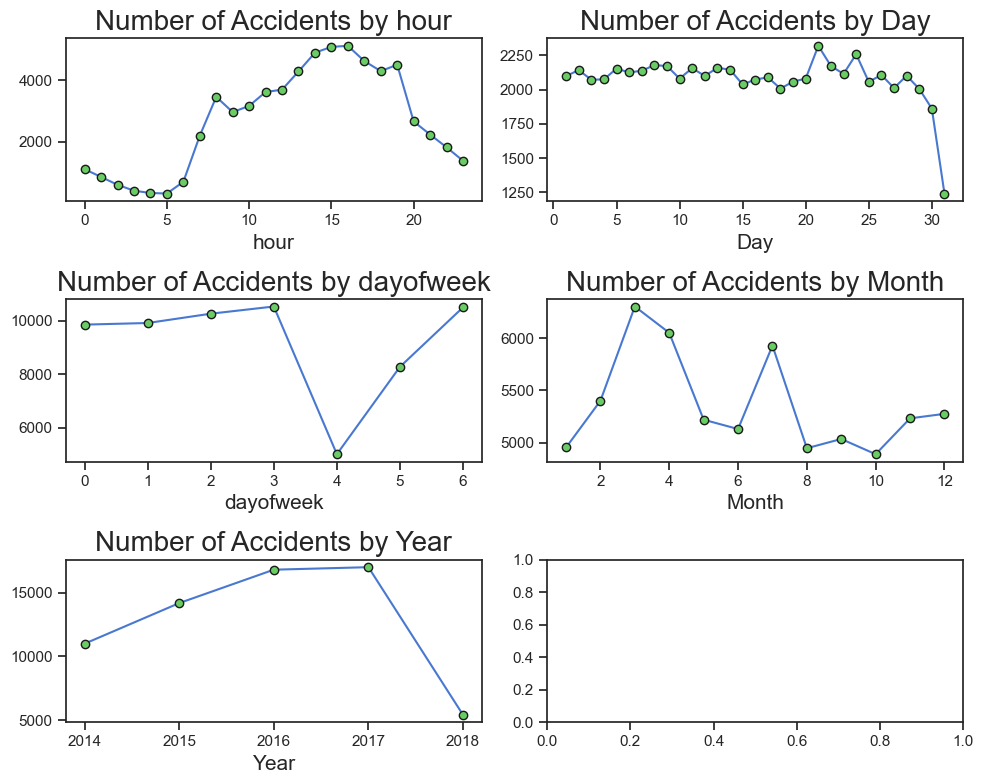

In [76]:
fig, axes = plt.subplots(3, 2, tight_layout=True, figsize=(10, 8))

for col, ax in zip(['hour', "Day", "dayofweek", "Month", 'Year'], axes.flatten()):

    df3.groupby(col)['Accident_ID'].nunique().\
        plot(ax=ax, marker="o", mfc="g", mec="k")
    
    if col=='Year':
        ax.set_xticks(np.arange(2014, 2019, 1))
    
    ax.set_title(f"Number of Accidents by {col}")

The above plots show total unique Accident_ID's by different time groups. There are some discernible patterns for most time groups.

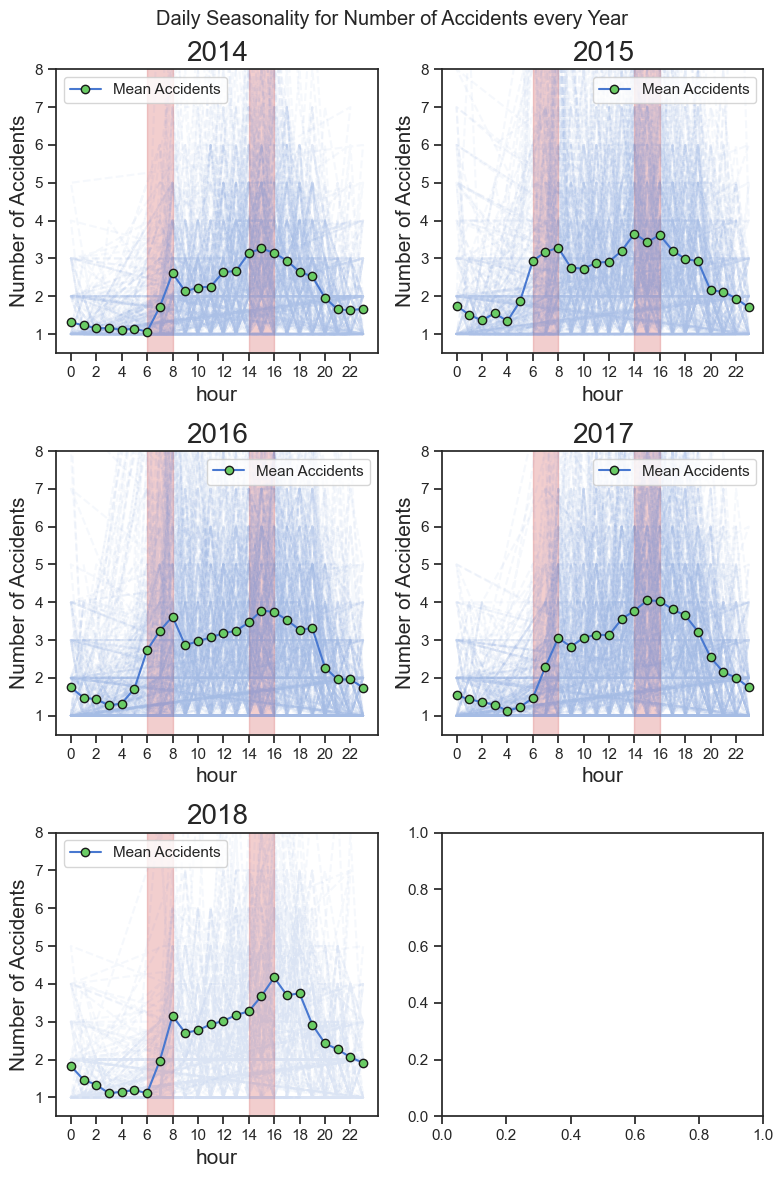

In [77]:
fig, axes = plt.subplots(3, 2, figsize=(8, 12), tight_layout = True)

for yr, ax in zip([2014, 2015, 2016, 2017, 2018], axes.flatten()):

    hrly_acc_cnt = []
    
    for i in np.arange(1, 13, 1):
        
        temp_df=\
        df3.query(f'Year=={yr} and Month=={i}').\
            groupby(['Day', 'hour'], as_index=False)['Accident_ID'].nunique()
        
        hrly_acc_cnt.extend(temp_df.pivot(index='Day', columns = 'hour').values)
        
        temp_df.plot(x = 'hour', y = 'Accident_ID', linestyle='--', mec='k', alpha=0.05, ax=ax, c='b', 
                     label='')
        
        ax.set_xticks(np.arange(0, 24, 2))
        ax.set_title(yr)
        
    pd.DataFrame(hrly_acc_cnt).mean().plot(ax=ax, marker="o", mfc="g", mec="k", label='Mean Accidents');
    ax.legend()
    ax.set_ylim(0.5, 8)
    ax.set_ylabel('Number of Accidents')
    ax.fill_between(x=(6, 8), y1=18, color='r', alpha = 0.3)
    ax.fill_between(x=(14, 16), y1=18, color='r', alpha = 0.3)

plt.suptitle('Daily Seasonality for Number of Accidents every Year');

The above plot shows Daily seasonality for each year. The pattern repeats every year where accidents are higher in the mornings, especially around 6 to 8 am, followed by in the afternoon at around 2 to 4 pm. Accidents starts to decrease after 6 pm.

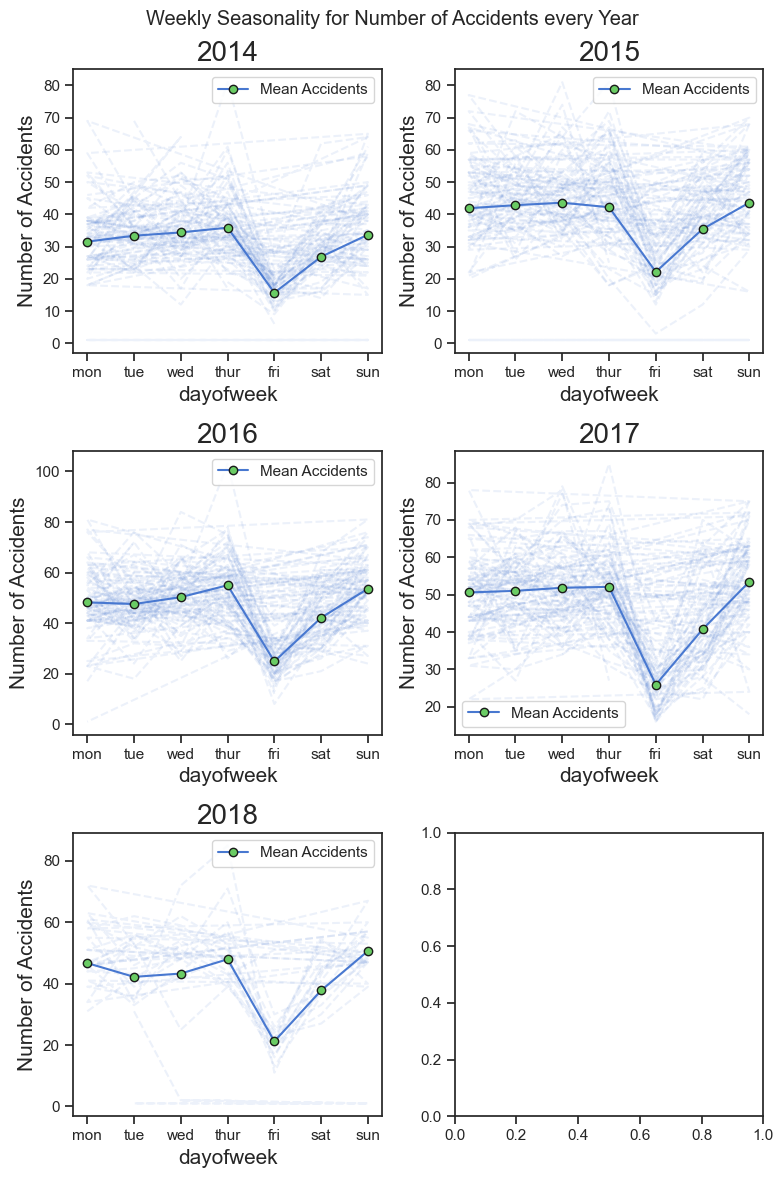

In [78]:
fig, axes = plt.subplots(3, 2, figsize=(8, 12), tight_layout = True)

for yr, ax in zip([2014, 2015, 2016, 2017, 2018], axes.flatten()):

    weekly_acc_cnt = []
    
    for i in np.arange(1, 13, 1):
        temp_df=\
        df3.query(f'Year=={yr} and Month=={i}').\
            groupby(['week', 'dayofweek'], as_index=False)['Accident_ID'].nunique()
        
        weekly_acc_cnt.extend(temp_df.pivot(index='week', columns = 'dayofweek').values)
        
        temp_df.plot(x = 'dayofweek', y = 'Accident_ID', linestyle='--', mec='k', alpha = 0.1, 
                     ax=ax, c='b', label='')
        
        ax.set_xticks(np.arange(0, 24, 2))
        ax.set_title(yr)
        
    pd.DataFrame(weekly_acc_cnt).mean().plot(ax=ax, marker="o", mfc="g", mec="k", label='Mean Accidents');
    ax.legend()
    ax.set_xticks(ticks=np.arange(0, 7, 1), labels=['mon', 'tue', 'wed', 'thur', 'fri', 'sat', 'sun'])
    ax.set_ylabel('Number of Accidents')
    
plt.suptitle('Weekly Seasonality for Number of Accidents every Year');

The above plot shows the weekly seasonality for each year. Again, the pattern repeats every year where Friday sees the lowest number of accidents compared to other days. Friday is a weekly holiday and the day where people go outside ti drive to and from mosques for prayers (since Jordan is a Muslim majority country). 

Following Friday, Saturday also sees low number of accidents compared to other day as Saturday is a weekend too. In Jordan, the weekends are on Friday and Saturday.

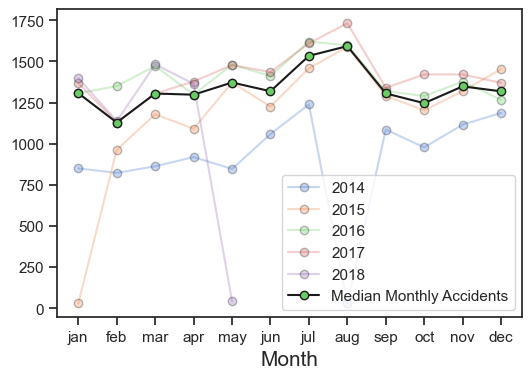

In [79]:
yrly_mnth_acc = df3.groupby(['Year', 'Month'], as_index=False)['Accident_ID'].nunique()

fig, ax = plt.subplots(figsize=(6, 4))

for yr in [2014, 2015, 2016, 2017, 2018]:
    
    yrly_mnth_acc.query(f"Year=={yr}").\
        plot(x='Month', y='Accident_ID', ax=ax, marker="o", mec="k", alpha=0.3, label=f'{yr}')
    
yrly_mnth_acc.pivot(index='Year', columns = 'Month')['Accident_ID'].median().\
    plot(x='Month', y='Accident_ID', ax=ax, marker="o", mec="k", mfc='g', c='k', 
         label='Median Monthly Accidents')

ax.set_xticks(
    ticks=np.arange(1, 13, 1), 
    labels=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
);
    
ax.legend();

Although there are some huge outliers during aug 2014, jan 2015 and may 2018, in general, July and August sees the highest median number of accidents compared to other months.

# Clustering Coordinates

The aim of this section is to cluster coordinates. I will use weighted kmeans algorithm to form location wise clusters. The weights will be based on number of accidents by coordinates.

Next we will check of the best clusters using metrics such as:

* **Silhouette Score**: The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1 . ***The best value is 1 and the worst value is -1***. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.


* **Davies Bouldin Score**: The score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters which are farther apart and less dispersed will result in a better score. The minimum score is zero, with ***lower values indicating better clustering***.

([Source](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score))

In [80]:
df3['no_of_accidents'] = df3.groupby(['lat', 'long'])['Accident_ID'].transform('nunique')

In [81]:
coords = df3[['lat', 'long', 'no_of_accidents']]

In [82]:
coords = coords.drop_duplicates(subset=['lat', 'long'], ignore_index=True)

  0%|          | 0/19 [00:00<?, ?it/s]

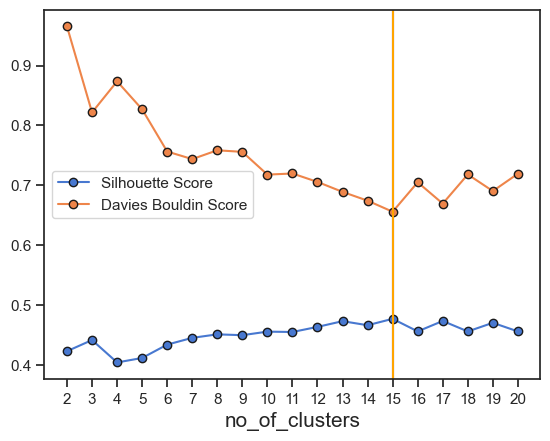

In [83]:
from sklearn.cluster import KMeans
from sklearn import metrics
seed = 42

X = coords[['lat', 'long']]
Y = coords['no_of_accidents']

#Identifying the best clusters
no_of_clusters = np.arange(2, 21, 1) 
results_ = pd.DataFrame(columns=['no_of_clusters', 'Silhouette Score','Davies Bouldin Score'])

#Choosing the best covariance type
for f in tqdm(no_of_clusters):
    kmeans = KMeans(n_clusters=f, random_state=seed, max_iter=1000)
    
    clusters = kmeans.fit_predict(X, sample_weight = Y)

    results_ = results_.append({
        "no_of_clusters" : f, 
        
        "Silhouette Score" : metrics.silhouette_score(X, clusters, random_state = seed),
        
        'Davies Bouldin Score' : metrics.davies_bouldin_score(X, clusters)
    }, ignore_index=True)

ax = results_.plot(x='no_of_clusters', y='Silhouette Score', marker="o", mec="k", 
                   label='Silhouette Score')

results_.plot( x='no_of_clusters', y='Davies Bouldin Score', marker="o", mec="k", 
              label='Davies Bouldin Score', ax=ax)

#Plotting scores
max_silh_score_ix = [results_['Silhouette Score'].argmax()]
min_db_score_ix = [results_['Davies Bouldin Score'].argmin()]

ax.axvline(
    results_['no_of_clusters'][max_silh_score_ix].values, 
    color = 'blue', 
    label = 'Highest Silhouette Score'
)

ax.axvline(
    results_['no_of_clusters'][min_db_score_ix].values, 
    color = 'orange', 
    label = 'Lowest Davies Bouldin Score'
)

ax.set_xticks(no_of_clusters);

In [84]:
kmeans = KMeans(n_clusters=15, random_state=seed, max_iter=1000)
clusters = kmeans.fit_predict(X, sample_weight = Y)

coords['kmeans_coord_clusters'] = clusters

In [85]:
coords

lat       long  no_of_accidents  kmeans_coord_clusters
0      31.965178  35.855927                1                      8
1      31.959605  35.858357                1                      8
2      31.975816  35.849201                1                      2
3      31.995424  35.850580                1                      6
4      31.982183  35.865161                1                      4
...          ...        ...              ...                    ...
37876  31.967225  35.862327                1                      5
37877  31.975543  35.861749                1                      5
37878  31.955000  35.836533                1                     11
37879  31.996256  35.848458                1                      6
37880  31.972230  35.838618                1                      7

[37881 rows x 4 columns]

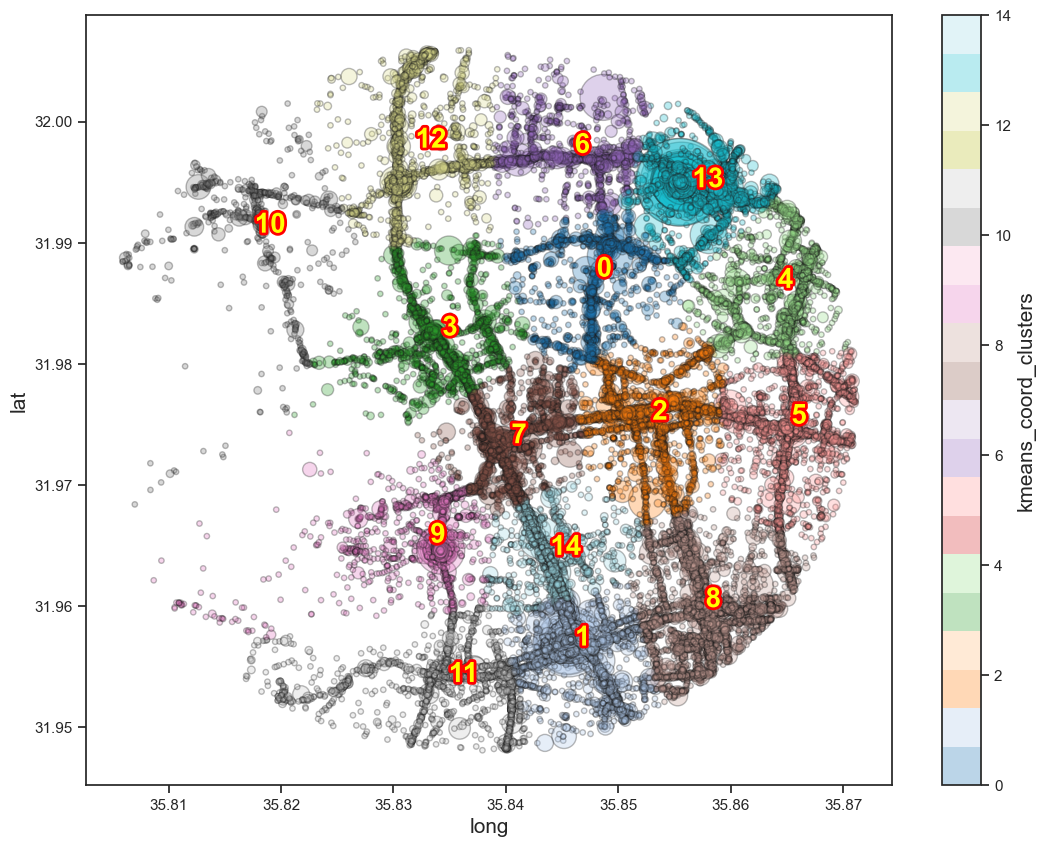

In [86]:
import matplotlib.patheffects as pe

fig, ax = plt.subplots(figsize=(13, 10))

temp_df = coords.query("no_of_accidents>0")

size=temp_df['no_of_accidents']*15

temp_df.plot(
    kind='scatter',
    x = 'long',
    y = 'lat',
    c = 'kmeans_coord_clusters',
    cmap='tab20',
    s=size,
    alpha=0.3,
    edgecolor='k',
    ax=ax
);

# plt.scatter(
#     kmeans.cluster_centers_[:, 1],
#     kmeans.cluster_centers_[:, 0],
#     c='red',
#     edgecolor='yellow'
# );

for i in set(temp_df['kmeans_coord_clusters']):
    ax.text(
        x=kmeans.cluster_centers_[i][1], 
        y=kmeans.cluster_centers_[i][0], 
        s=f'{i}',
        color='yellow',
        fontsize=20,
        fontweight='bold',
        path_effects=[pe.withStroke(linewidth=4, foreground="red")]
    )

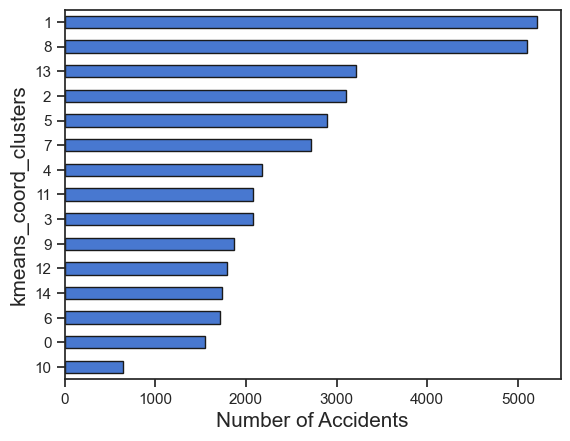

In [87]:
coords.groupby('kmeans_coord_clusters').size().sort_values().plot(kind='barh', edgecolor='k');
plt.xlabel('Number of Accidents');

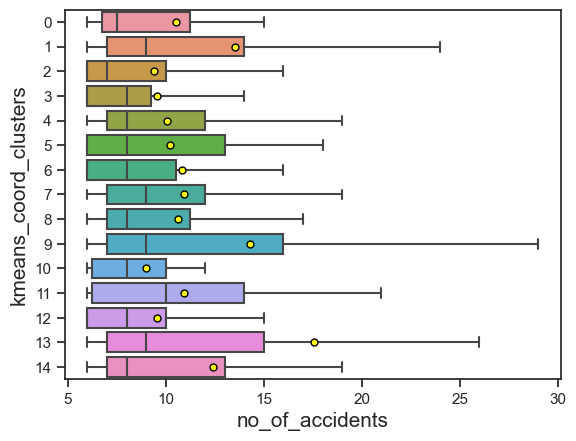

In [88]:
#Filtering locations with 5 or less accidents
sns.boxplot(
    x='no_of_accidents',
    y='kmeans_coord_clusters',
    data=coords.query('no_of_accidents > 5'),
    orient='h',
    showfliers=False, #To remove outliers, otherwise the median of the boxplots would not be displayed properly
    showmeans=True, #To display mean
    meanprops={
        "marker": "o",
        "markerfacecolor": "yellow",
        "markeredgecolor": "black",
        "markersize": "5"
    }
);

#The yellow markers indicates the mean number of accidents

In [89]:
#assigning the clusters to the main dataset df3
for i in tqdm(set(coords['kmeans_coord_clusters'])):

    lat_coord = set(coords.query(f"kmeans_coord_clusters=={i}")['lat'])
    long_coord = set(coords.query(f"kmeans_coord_clusters=={i}")['long'])
    
    df3.loc[df3['lat'].isin(lat_coord) & df3['long'].isin(long_coord), 'loc_cluster'] = i

  0%|          | 0/15 [00:00<?, ?it/s]

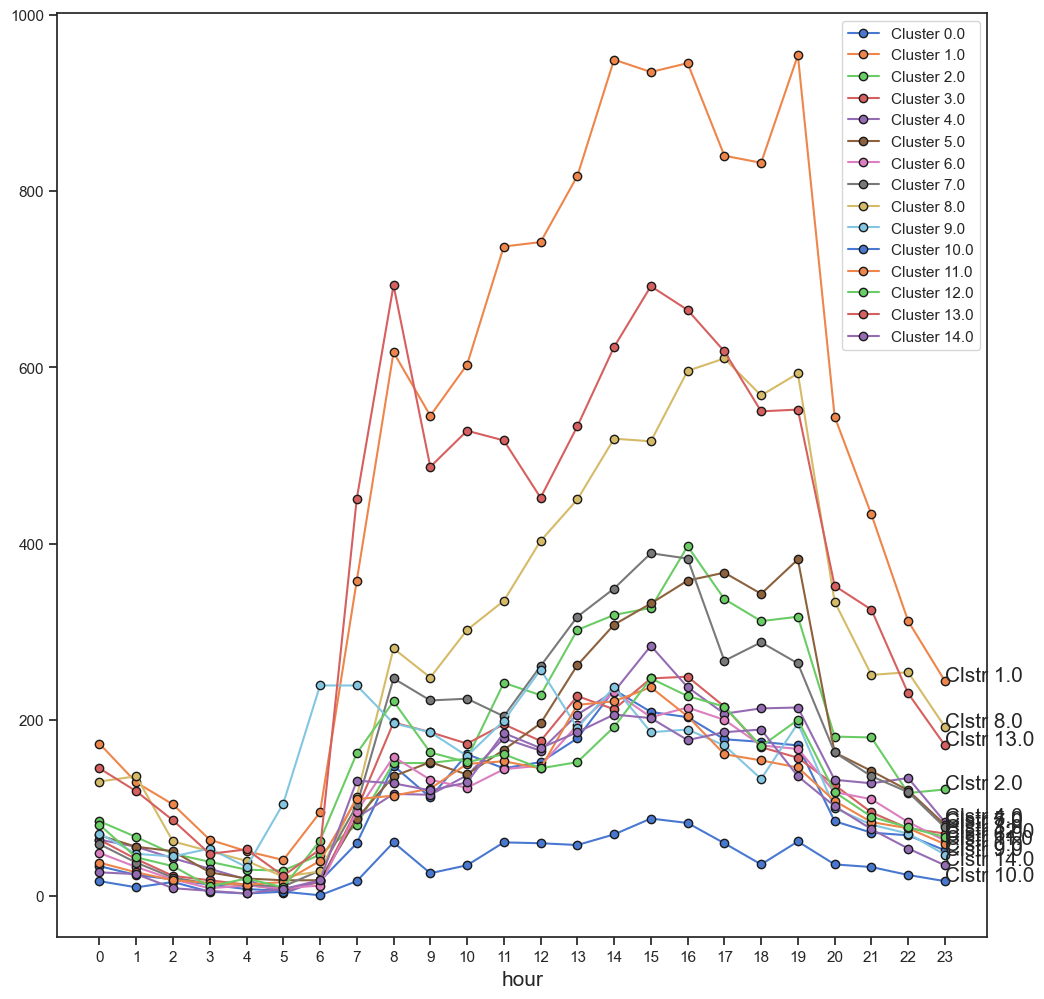

In [90]:
hour_clstr_acc = \
df3.groupby(['loc_cluster', 'hour'], as_index=False)['Accident_ID'].nunique()

fig, ax = plt.subplots(figsize=(12, 12))

for i in set(hour_clstr_acc['loc_cluster']):
    
    hour_clstr_acc.query(f"loc_cluster=={i}").\
        plot(x="hour", y="Accident_ID", marker='o', mec='k',  ax=ax, label=f'Cluster {i}')
    
    xy_coord = hour_clstr_acc.query(f"loc_cluster=={i}").iloc[-1, [1, 2]].values
    
    ax.annotate(text=f"Clstr {i}",
                xy=xy_coord,
                fontsize=15,
#                 xytext=xy_coord + np.array([24, 5])
               )
    
    ax.set_xticks(np.arange(0, 24, 1));

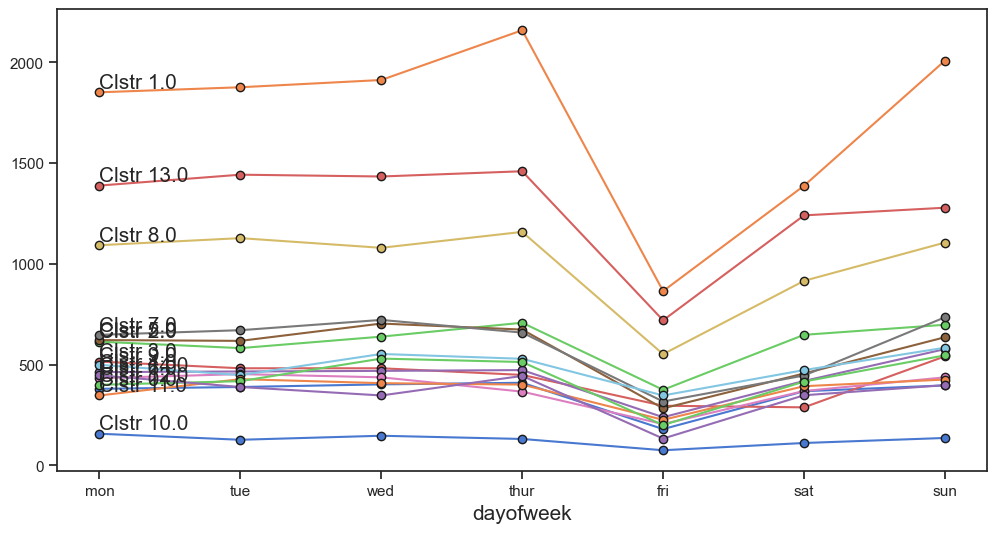

In [91]:
dayofweek_clstr_acc = \
df3.groupby(['loc_cluster', 'dayofweek'], as_index=False)['Accident_ID'].nunique()

fig, ax = plt.subplots(figsize=(12, 6))

for i in set(dayofweek_clstr_acc['loc_cluster']):
    
    dayofweek_clstr_acc.query(f"loc_cluster=={i}").\
        plot(x="dayofweek", y="Accident_ID", marker='o', mec='k',  ax=ax, label="")
    
    ax.get_legend().remove()
    
    xy_coord = dayofweek_clstr_acc.query(f"loc_cluster=={i}").iloc[0, [1, 2]].values
    
    ax.annotate(text=f"Clstr {i}",
                xy=xy_coord,
                fontsize=15,
                xytext=xy_coord + np.array([0, 20])
               )
    
    ax.set_xticks(np.arange(0, 7, 1), labels=['mon', 'tue', 'wed', 'thur', 'fri', 'sat', 'sun']);

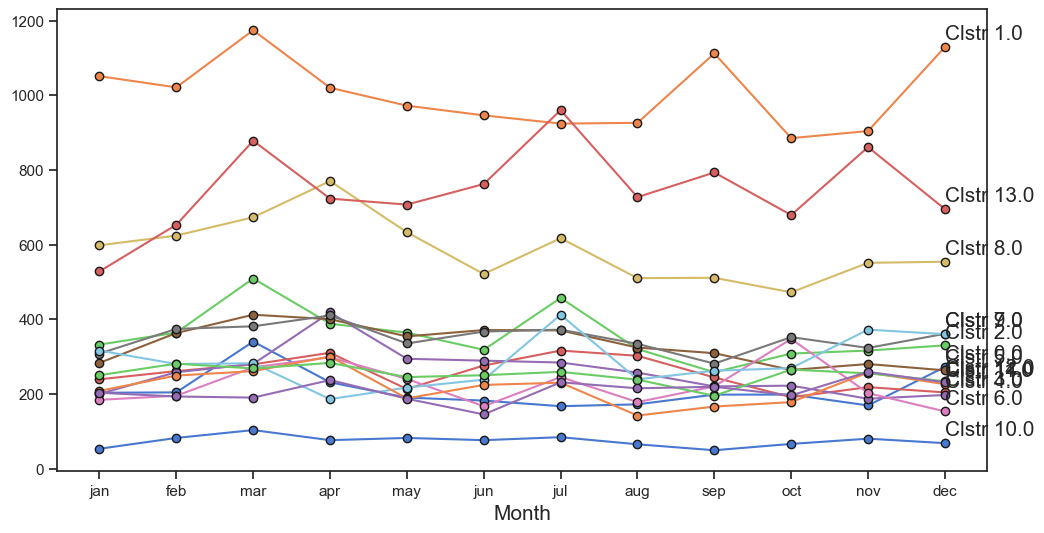

In [92]:
month_clstr_acc = \
df3.groupby(['loc_cluster', 'Month'], as_index=False)['Accident_ID'].nunique()

fig, ax = plt.subplots(figsize=(12, 6))

for i in set(month_clstr_acc['loc_cluster']):
    
    month_clstr_acc.query(f"loc_cluster=={i}").\
        plot(x="Month", y="Accident_ID", marker='o', mec='k',  ax=ax, label="")
    
    ax.get_legend().remove()
    
    xy_coord = month_clstr_acc.query(f"loc_cluster=={i}").iloc[-1, [1, 2]].values
    
    ax.annotate(text=f"Clstr {i}",
                xy=xy_coord,
                fontsize=15,
                xytext=xy_coord + np.array([0, 20])
               )
    
    ax.set_xticks(
        ticks=np.arange(1, 13, 1),
        labels=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    );

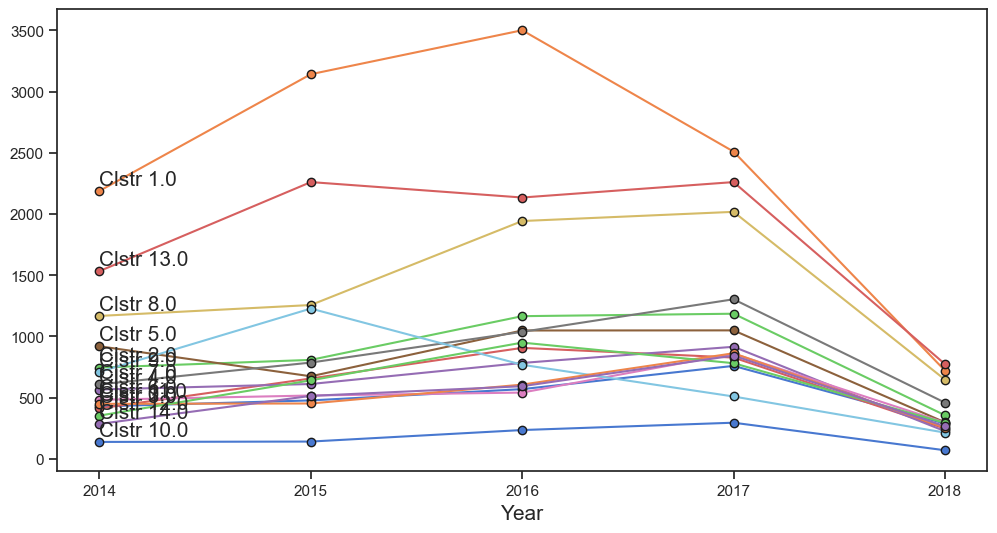

In [93]:
year_clstr_acc = \
df3.groupby(['loc_cluster', 'Year'], as_index=False)['Accident_ID'].nunique()

fig, ax = plt.subplots(figsize=(12, 6))

for i in set(year_clstr_acc['loc_cluster']):
    
    year_clstr_acc.query(f"loc_cluster=={i}").\
        plot(x="Year", y="Accident_ID", marker='o', mec='k',  ax=ax, label=f'Cluster {i}')
    
    ax.get_legend().remove()
    
    xy_coord = year_clstr_acc.query(f"loc_cluster=={i}").iloc[0, [1, 2]].values
    
    ax.annotate(text=f"Clstr {i}",
                xy=xy_coord,
                fontsize=15,
                xytext=xy_coord + np.array([0, 50])
               )
    
    ax.set_xticks(ticks=np.arange(2014, 2019, 1));

# Effect of Holidays

In [94]:
holiday_df = pd.read_csv('jordan_holidays_observance.csv')

In [95]:
holiday_df['date']=pd.to_datetime(holiday_df['date'])
holiday_df

date          holiday_name      holiday_type
0   2014-01-01        New Year's Day  National holiday
1   2014-01-13    Prophet's Birthday  National holiday
2   2014-03-20         March Equinox            Season
3   2014-04-13           Palm Sunday  Optional Holiday
4   2014-04-18  Orthodox Good Friday        Observance
..         ...                   ...               ...
321 2022-09-23     September Equinox            Season
322 2022-10-08    Prophet's Birthday  National holiday
323 2022-12-22     December Solstice            Season
324 2022-12-25         Christmas Day  National holiday
325 2022-12-26            Boxing Day  Optional Holiday

[326 rows x 3 columns]

In [96]:
# Merging both new crash dataset and holiday df using left join
df3=df3.merge(holiday_df, how='left', left_on='Date', right_on='date').drop('date', axis=1)

In [97]:
#Removing seasons
df3.loc[df3['holiday_type'].eq('Season'), ['holiday_name', 'holiday_type']] = np.nan

In [98]:
#Imputing days from "Ramadan Begins to Eid al-fitr as Ramadan"
ramadan_start = df3.loc[df3['holiday_name'].eq('Ramadan begins'), 'Date'].unique()
ramadan_end = df3.loc[df3['holiday_name'].eq('Eid al-Fitr'), 'Date'].unique()

for s, e in zip(ramadan_start, ramadan_end):
    
    try:
        df3.loc[df3['Date'].between(s, e, inclusive='neither') & df3['holiday_name'].isna(), 
                ['holiday_name', 'holiday_type']] = \
        ["Ramadan", "Observance"]
        
    except IndexError:
        df3.loc[df3[df3['Date'].eq(s)].index[0]:, ['holiday_name', 'holiday_type']] = \
        ["Ramadan", "Observance"]

In [99]:
df3['holiday_name'] = df3['holiday_name'].replace('Ramadan begins', 'Ramadan')

In [100]:
df3.loc[df3['holiday_name'].str.contains(r'holiday', na=False), 'holiday_name'] = \
df3.loc[df3['holiday_name'].str.contains(r'holiday', na=False), 'holiday_name'].\
    replace(r' holiday$', '', regex=True)

In [101]:
#Holiday_name as null values will be considered as non holidays
df3.loc[df3['holiday_name'].isna(), ['holiday_name', 'holiday_type']] = 'Non Holiday'

In [102]:
df3[["holiday_name", "holiday_type"]].drop_duplicates().sort_values('holiday_type', ignore_index=True)

holiday_name      holiday_type
0           New Year's Day  National holiday
1   One-off Public Holiday  National holiday
2            Christmas Day  National holiday
3        Muharram/New Year  National holiday
4              Eid al-Adha  National holiday
5              Eid al-Fitr  National holiday
6         Independence Day  National holiday
7     Extra Census Holiday  National holiday
8               Labour Day  National holiday
9       Prophet's Birthday  National holiday
10           Easter Monday  National holiday
11             Non Holiday       Non Holiday
12           Easter Sunday        Observance
13      Al Isra' wal Miraj        Observance
14                 Ramadan        Observance
15             Good Friday        Observance
16    Orthodox Good Friday        Observance
17           Easter Monday        Observance
18  Orthodox Easter Monday  Optional Holiday
19     Orthodox Easter Day  Optional Holiday
20             Palm Sunday  Optional Holiday
21              Boxing Day  Optional Holiday

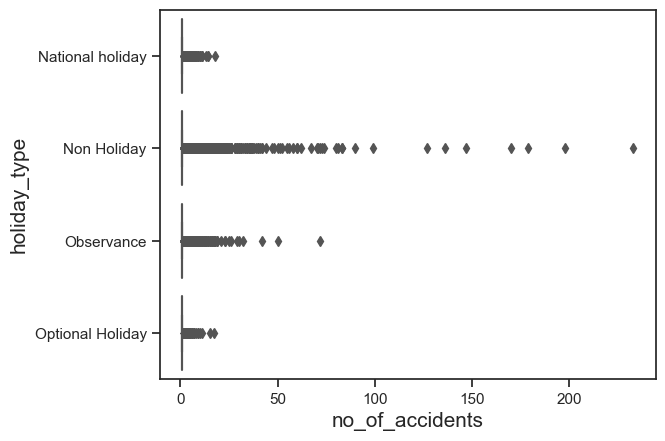

In [103]:
hol_type_acc_cnt=\
df3.groupby(['holiday_type', 'lat', 'long'], as_index=False)['Accident_ID'].nunique().\
    drop(['lat', 'long'], axis=1).rename(columns={'Accident_ID' : 'no_of_accidents'})

sns.boxplot(
    x='no_of_accidents',
    y='holiday_type',
    data=hol_type_acc_cnt,
    orient='h',
#     showfliers=False
);

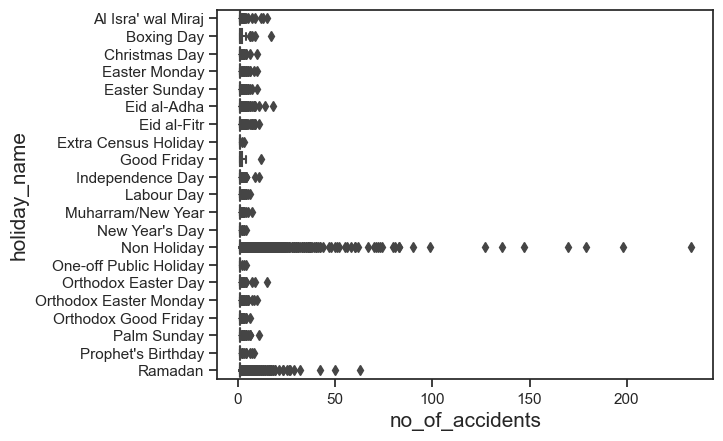

In [104]:
hol_name_acc_cnt=\
df3.groupby(['holiday_name', 'lat', 'long'], as_index=False)['Accident_ID'].nunique().\
    drop(['lat', 'long'], axis=1).rename(columns={'Accident_ID' : 'no_of_accidents'})

sns.boxplot(
    x='no_of_accidents',
    y='holiday_name',
    data=hol_name_acc_cnt,
    orient='h',
    whis=3
);

In [105]:
from scipy import stats

nat_hol = hol_type_acc_cnt.query('holiday_type=="National holiday"')['no_of_accidents'].values
non_hol = hol_type_acc_cnt.query('holiday_type=="Non Holiday"')['no_of_accidents'].values
Observance = hol_type_acc_cnt.query('holiday_type=="Observance"')['no_of_accidents'].values
opt_hol = hol_type_acc_cnt.query('holiday_type=="Optional Holiday"')['no_of_accidents'].values

hol_types = {
    'National Holidays' : nat_hol,
    'Observance' : Observance,
    'Optional Holidays' : opt_hol
}

for name, hol_type in hol_types.items():
    
    print(f'Non Holidays vs {name}')
    print('*'*len(f'Non Holidays vs {name}'))
    
    alpha = 0.01
    H, p = stats.kruskal(non_hol, hol_type)

    print(f"""
Null Hypothesis (H0): Median Number of accidents are equal for both non holidays and {name}.

Alternative hypothesis (H1): There is a difference between median number of accidents between 
non holidays and {name}.
    """)
    print(f'H-Value: {H:.3f}')
    print(f'P-value: {p:.3f}')
    print(f'Alpha: {alpha}')
    print()

    if p <= alpha:
        print(f'P-value less than alpha - Reject H0. Median number of Accidents differs during {name}')
    else:
        print('P-value higher than alpha - Cannot Reject H0. No difference in median number of accidents')

    print()
    print()

Non Holidays vs National Holidays
*********************************

Null Hypothesis (H0): Median Number of accidents are equal for both non holidays and National Holidays.

Alternative hypothesis (H1): There is a difference between median number of accidents between 
non holidays and National Holidays.
    
H-Value: 9.243
P-value: 0.002
Alpha: 0.01

P-value less than alpha - Reject H0. Median number of Accidents differs during National Holidays


Non Holidays vs Observance
**************************

Null Hypothesis (H0): Median Number of accidents are equal for both non holidays and Observance.

Alternative hypothesis (H1): There is a difference between median number of accidents between 
non holidays and Observance.
    
H-Value: 4.384
P-value: 0.036
Alpha: 0.01

P-value higher than alpha - Cannot Reject H0. No difference in median number of accidents


Non Holidays vs Optional Holidays
*********************************

Null Hypothesis (H0): Median Number of accidents are equal for

The Kruskal-Wallis test is a non-parametric statistical test used to compare the median of multiple groups. It is used when the data are not normally distributed or the variances are not equal. It is similar to the one-way ANOVA, but it is more robust to violations of the assumptions of normality and equal variances.

The p-value obtained from the Kruskal-Wallis test indicates the probability of observing the test statistic (or a more extreme one) if the null hypothesis is true. If the p-value is less than the chosen significance level (usually 0.05), then the null hypothesis can be rejected, and it can be concluded that there is a significant difference between the medians of the groups.

In summary, the Kruskal-Wallis test can yield a p-value less than 0.05 even if the medians of the groups are the same if the distribution of the data within each group is significantly different from the others, regardless of the sample size.

From the above statistical test, the median accidents during national holidays is different from median accidents during non holidays. But the same cannot be said for both Observance and optional holidays.

In [106]:
ramadan = hol_name_acc_cnt.query('holiday_name=="Ramadan"')['no_of_accidents'].values
non_hol = hol_name_acc_cnt.query('holiday_name=="Non Holiday"')['no_of_accidents'].values

alpha = 0.05
H, p = stats.kruskal(non_hol, ramadan)

print("""
Null Hypothesis (H0): Median Number of accidents are equal for both non holidays and Ramadan.
Alternative hypothesis (H1): There is a difference between median number of accidents between 
non holidays and Ramadan.
""")
print(f'H-Value: {H:.3f}')
print(f'P-value: {p:.3f}')
print(f'Alpha: {alpha}')
print()

if p <= alpha:
    print(f'P-value less than alpha - Reject H0. Number of Accidents differs during Ramadan')
else:
    print('P-value higher than alpha - Cannot Reject H0. No difference in median accidents')


Null Hypothesis (H0): Median Number of accidents are equal for both non holidays and Ramadan.
Alternative hypothesis (H1): There is a difference between median number of accidents between 
non holidays and Ramadan.

H-Value: 4.547
P-value: 0.033
Alpha: 0.05

P-value less than alpha - Reject H0. Number of Accidents differs during Ramadan


## Ramadan vs Non Holidays

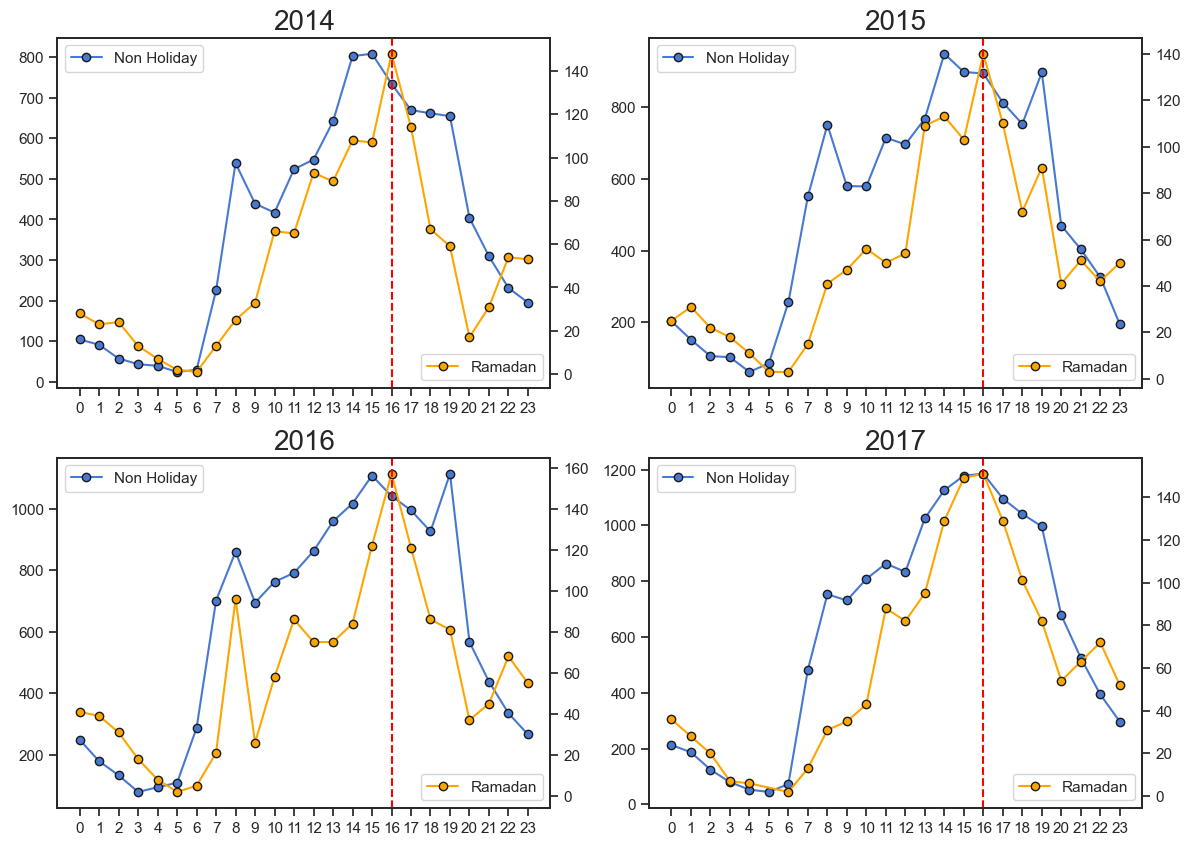

In [107]:
ramadan_acc_hr = \
df3.loc[df3['holiday_name'].str.contains('Ramadan|Non Holiday')].\
    groupby(['holiday_name', 'Year', 'hour'], as_index=False)['Accident_ID'].nunique()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for year, ax in zip([2014, 2015, 2016, 2017], axes.flatten()):
    
    ax2 = ax.twinx()
    
    ramadan_acc_hr.loc[
        ramadan_acc_hr['Year'].eq(year) & ramadan_acc_hr['holiday_name'].eq('Non Holiday')
    ].plot(x='hour', y='Accident_ID', marker='o', mec='k', ax=ax, label="Non Holiday")
    
    ramadan_acc_hr.loc[
        ramadan_acc_hr['Year'].eq(year) & ramadan_acc_hr['holiday_name'].ne('Non Holiday')
    ].plot(x='hour', y='Accident_ID', marker='o', mec='k', ax=ax2, label="Ramadan", c='orange')
    
    ax.set_xticks(np.arange(0, 24, 1))
    ax.set_xlabel("")
    ax.legend(loc="upper left")
    ax2.legend(loc="lower right")
    
    ax2.axvline(16, color='red', linestyle='--')
    
    ax.set_title(year);

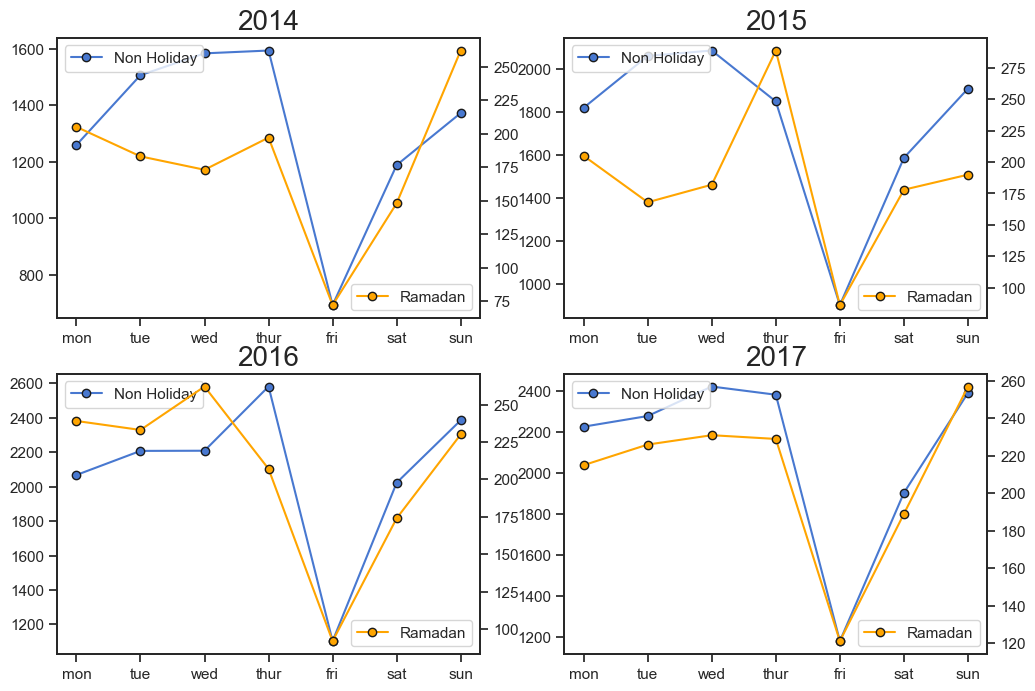

In [108]:
ramadan_acc_dayofweek = \
df3.loc[df3['holiday_name'].str.contains('Ramadan|Non Holiday')].\
    groupby(['holiday_name', 'Year', 'dayofweek'], as_index=False)['Accident_ID'].nunique()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for year, ax in zip([2014, 2015, 2016, 2017], axes.flatten()):
    
    ax2 = ax.twinx()
    
    ramadan_acc_dayofweek.loc[
        ramadan_acc_dayofweek['Year'].eq(year) & ramadan_acc_dayofweek['holiday_name'].eq('Non Holiday')
    ].plot(x='dayofweek', y='Accident_ID', marker='o', mec='k', ax=ax, label="Non Holiday")
    
    ramadan_acc_dayofweek.loc[
        ramadan_acc_dayofweek['Year'].eq(year) & ramadan_acc_dayofweek['holiday_name'].ne('Non Holiday')
    ].plot(x='dayofweek', y='Accident_ID', marker='o', mec='k', ax=ax2, label="Ramadan", c='orange')
    
    ax.set_xticks(ticks=np.arange(0, 7, 1), labels=['mon', 'tue', 'wed', 'thur', 'fri', 'sat', 'sun'])
    ax.set_xlabel("")
    ax.legend(loc="upper left");
    ax2.legend(loc="lower right");
    
    ax.set_title(year);

### Non Holidays vs National Holidays

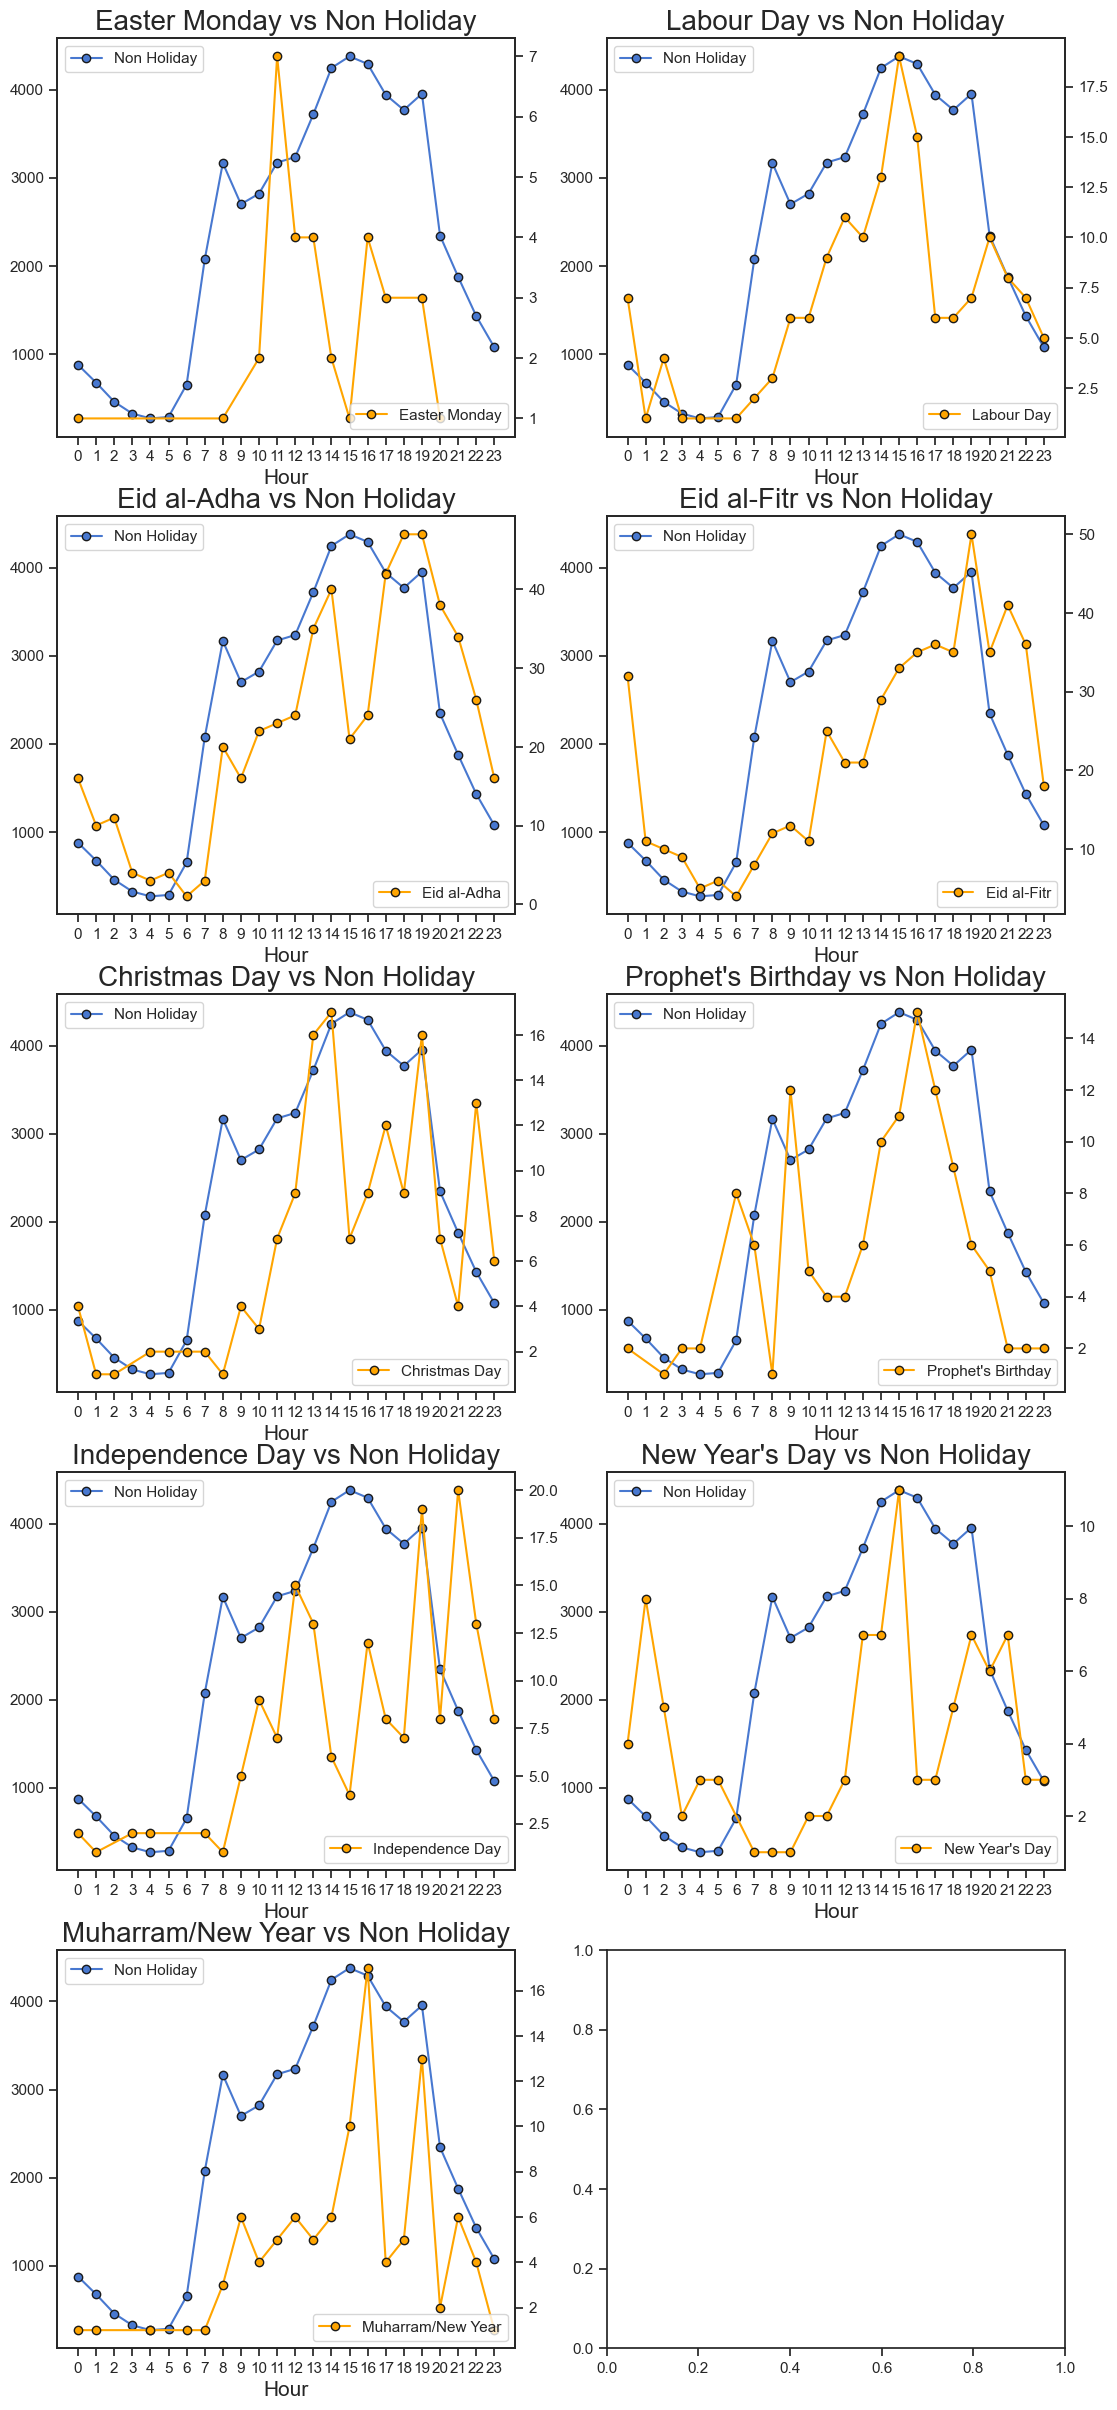

In [109]:
query="holiday_type in ('National holiday', 'Non Holiday') and "\
        "holiday_name not in ('One-off Public Holiday', 'Extra Census Holiday')"

nat_hol_hrly_acc=\
df3.query(query).groupby(['holiday_name', 'hour'], as_index=False)['Accident_ID'].nunique()
#         groupby(['holiday_name', 'hour'], as_index=False)['Accident_ID'].median()


nat_hol_list = \
set(nat_hol_hrly_acc.loc[nat_hol_hrly_acc['holiday_name'].ne('Non Holiday'), 'holiday_name'])

fig, axes = plt.subplots(5, 2, figsize=(13, 30))

for holiday, ax in zip(nat_hol_list, axes.flatten()):
    
    ax2 = ax.twinx()
    
    nat_hol_hrly_acc.loc[nat_hol_hrly_acc['holiday_name'].eq('Non Holiday')].\
        plot(x='hour', y='Accident_ID', marker='o', mec='k', ax=ax, label="Non Holiday")
    
    nat_hol_hrly_acc.loc[nat_hol_hrly_acc['holiday_name'].eq(holiday)].\
        plot(x='hour', y='Accident_ID', marker='o', mec='k', ax=ax2, label=holiday, c='orange')
    
    
    ax.set_xticks(np.arange(0, 24, 1))
    ax.set_xlabel("Hour")
    ax.legend(loc="upper left")
    ax2.legend(loc="lower right")
    
#     ax2.axvline(16, color='red', linestyle='--')
    
    ax.set_title(f'{holiday} vs Non Holiday');

# Weather Data

In [110]:
weather_df = \
pd.read_csv('JordanWeather_2014to2021.csv', parse_dates = ['date'], index_col=['date']).asfreq('1H')

In [111]:
weather_df = weather_df.drop(['precipitation', 'heat_index'], axis = 1)

In [112]:
weather_df.isna().sum()

temperature           1196
weather_condition     1187
dew_point             1287
humidity              1196
pressure              1203
visibility            1187
wind_condition        1238
gust                 69889
wind_speed            1795
uv_desc               1503
uv_index              1187
clouds_condition      1187
dtype: int64

#### Cleaning Windspeed

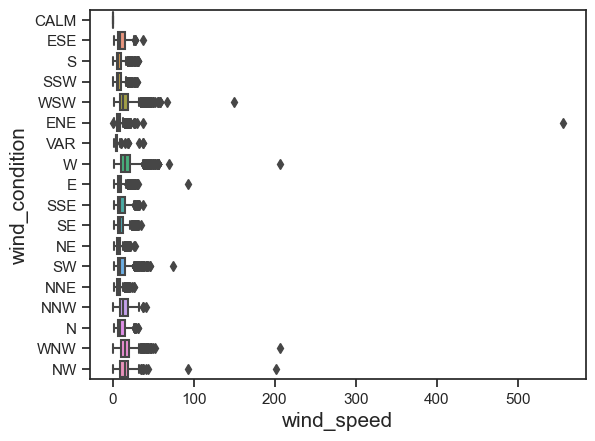

In [113]:
sns.boxplot(
    x='wind_speed',
    y='wind_condition',
    data=weather_df,
    orient='h',
);

There are some extreme outliers. These will be removed and then interpolated.

In [114]:
#Wind_condition 'CALM' has 0 wind speed
weather_df.loc[weather_df['wind_condition'].eq('CALM'), 'wind_speed'] = 0.0

In [115]:
#Replacing outliers as null
weather_df.loc[weather_df['wind_speed'].gt(70), 'wind_speed'] = np.nan

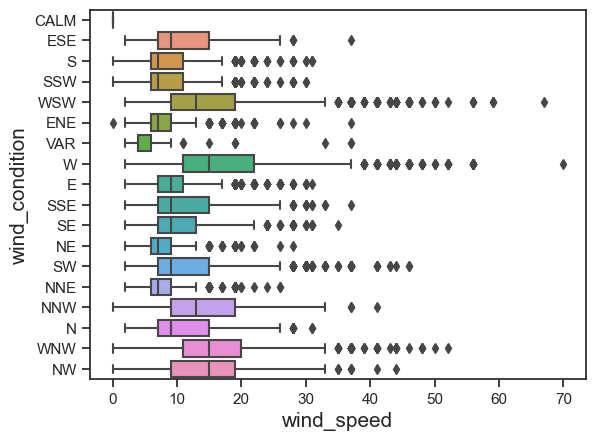

In [116]:
sns.boxplot(
    x='wind_speed',
    y='wind_condition',
    data=weather_df,
    orient='h',
);

### UV Index

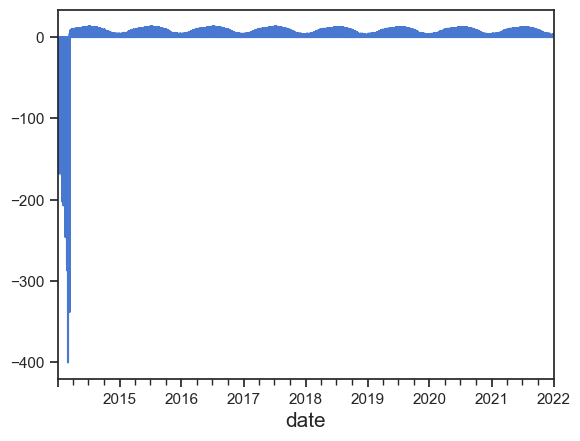

In [117]:
weather_df['uv_index'].plot();

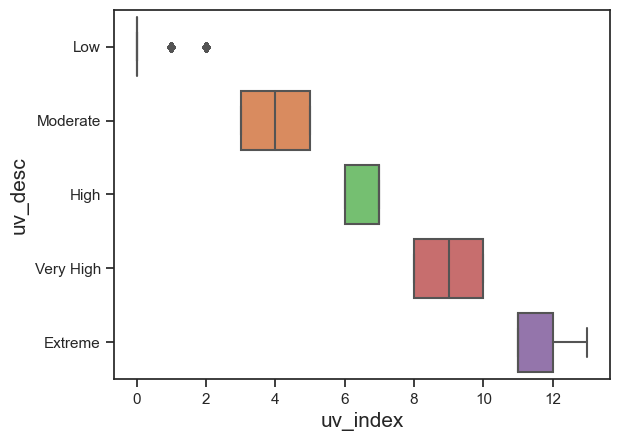

In [118]:
sns.boxplot(
    x='uv_index',
    y='uv_desc',
    data=weather_df,
    orient='h',
);

In [119]:
#Values before this data will be set 0
weather_df.loc[(weather_df.index < "2014-03-14 18:00:00"), ['uv_desc', 'uv_index']] = ['Low', 0.0]

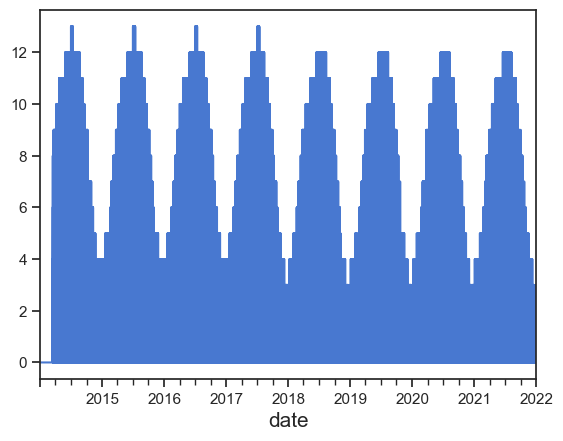

In [120]:
weather_df['uv_index'].plot();

In [121]:
#Imputing all Numerical columns with 'nearest' interpolation

weather_df[["temperature", "dew_point", "humidity", "pressure", "visibility", "wind_speed", "uv_index"]]=\
weather_df[["temperature", "dew_point", "humidity", "pressure", "visibility", "wind_speed","uv_index"]].\
interpolate('nearest')

In [122]:
#Handling null values in categorical columns
weather_df.loc[
    weather_df['wind_speed'].eq(0) & weather_df['wind_condition'].isna(), 'wind_condition'
] = "CALM"

In [123]:
weather_df.loc[
    weather_df['wind_condition'].ne('CALM'), 
    ["weather_condition", "wind_condition", "uv_desc", "clouds_condition"]
] = \
weather_df.loc[
    weather_df['wind_condition'].ne('CALM'), 
    ["weather_condition", "wind_condition", "uv_desc", "clouds_condition"]
].ffill()

In [124]:
weather_df[['weather_condition', 'uv_desc', 'clouds_condition']] = \
weather_df[['weather_condition', 'uv_desc', 'clouds_condition']].ffill()

In [125]:
#For gust, there are some rows that do have values for the previous and after hours. Therefore
#The null values in these partcular rows will be imputed with the previous value.

mask = \
weather_df['gust'].isnull() &\
weather_df['gust'].shift(1).notnull() &\
weather_df['gust'].shift(-1).notnull()

ix = weather_df[mask].index

for i in ix:
    weather_df.loc[i, 'gust'] = weather_df.loc[i-pd.Timedelta("1 hour"), 'gust']

In [126]:
#The remaining will be imputed as 0
weather_df['gust'] = weather_df['gust'].fillna(0)

In [127]:
# weather_df.to_csv('JordanWeather_2014to2021_cleaned.csv')

# Weather data with Precipitation

In [128]:
precip_data = pd.read_csv('AmmanJordan_DailyPrecip_2014to2020.csv', index_col=['date'], 
                          parse_dates=['date'])

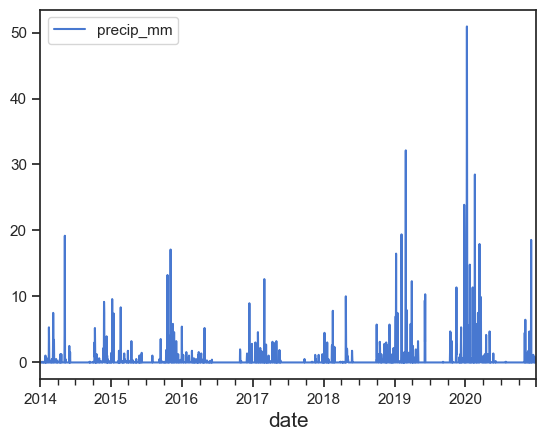

In [129]:
precip_data.plot(y='precip_mm');

# Weather vs Accidents

In [130]:
num_cols = weather_df.select_dtypes(exclude='object').columns

agg_func = {col:'mean' if col in num_cols else lambda x:pd.Series.mode(x)[0] for col in weather_df.columns}

daily_weather_acc=\
df3.set_index('Accident_Date').resample('D')['Accident_ID'].nunique().to_frame('no_of_accidents').\
    join(weather_df.resample('d').agg(agg_func), how='left').\
        join(precip_data, how='left').drop('precip_in', axis=1)

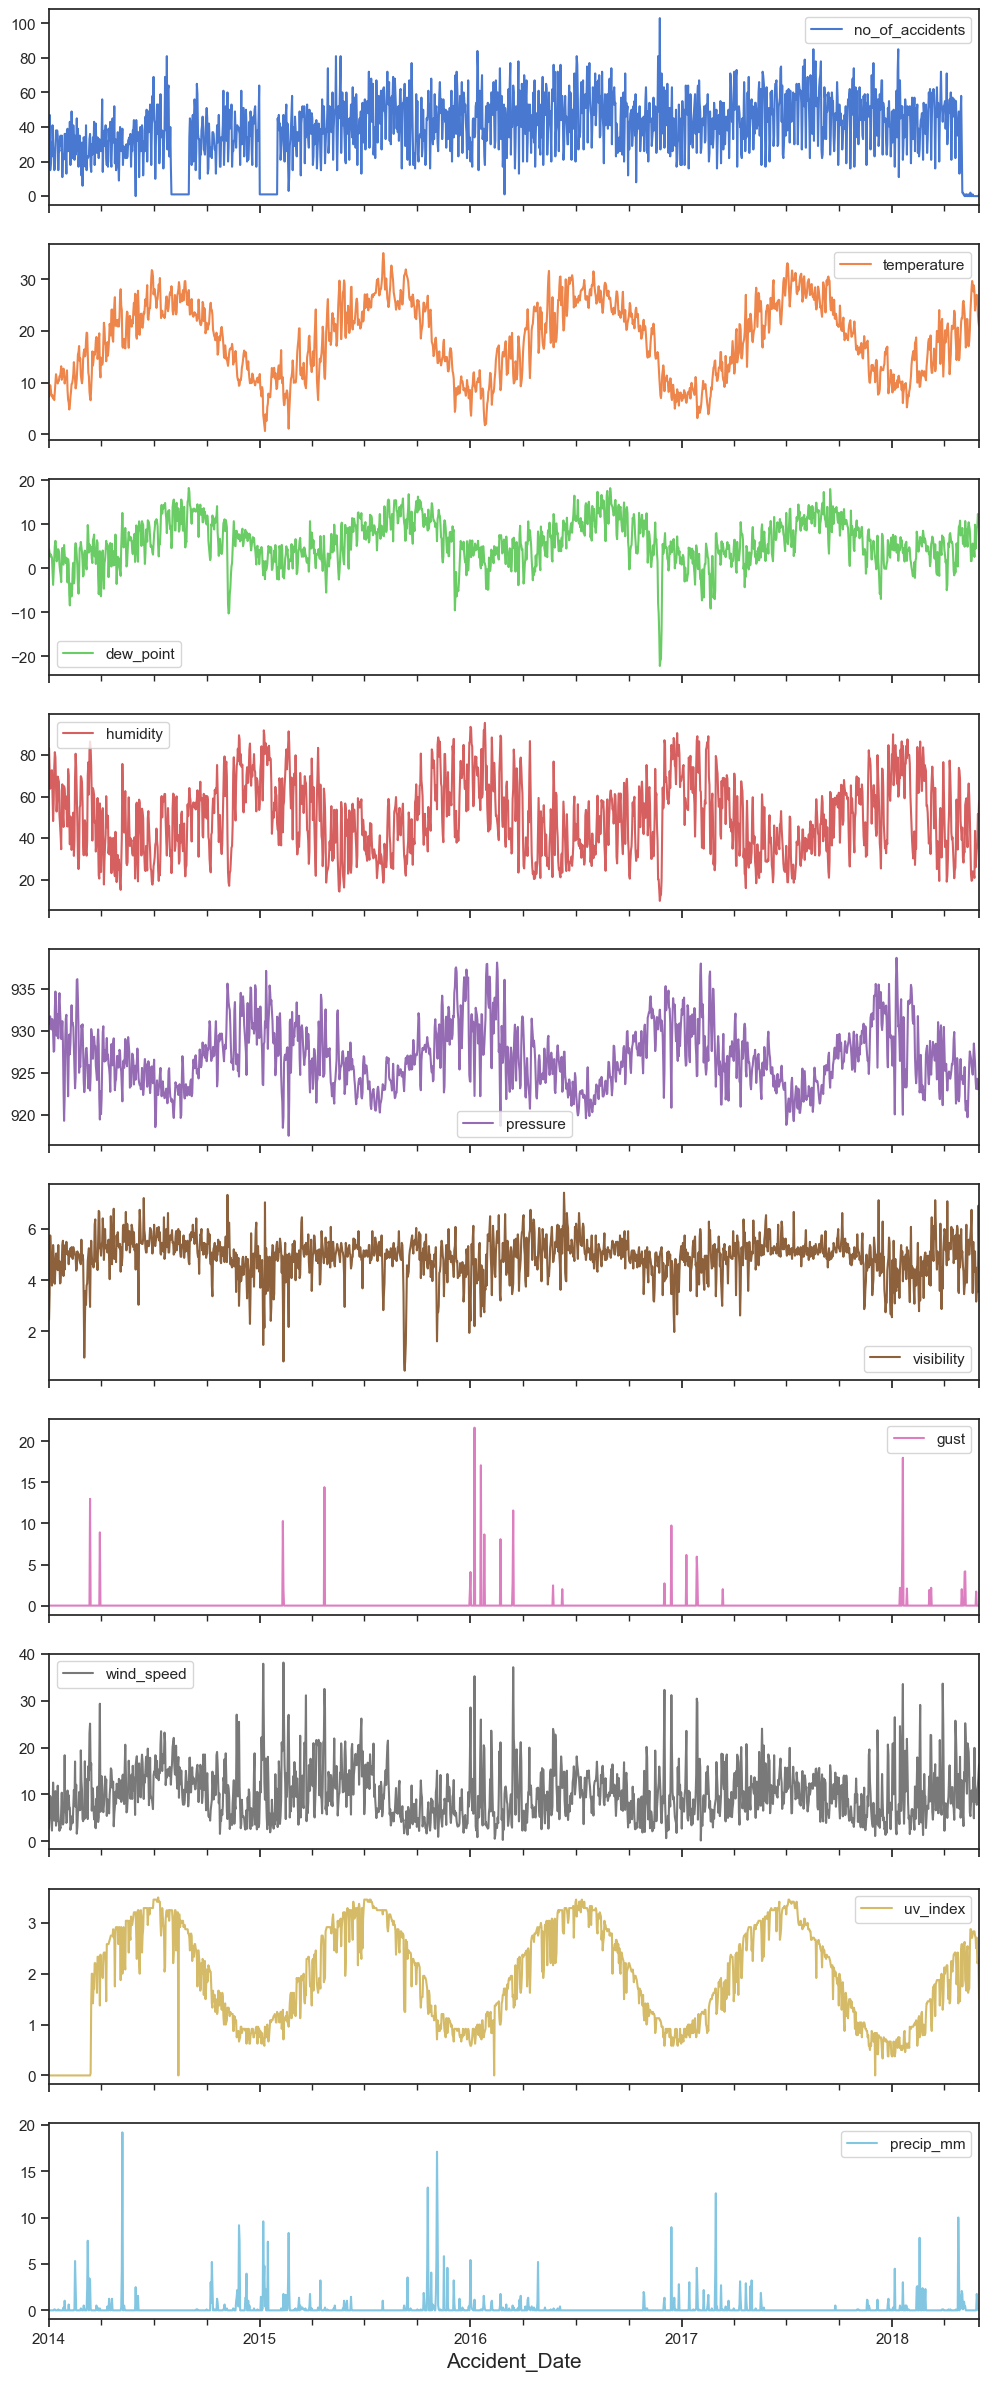

In [131]:
daily_weather_acc.plot(subplots=True, figsize=(12, 30));

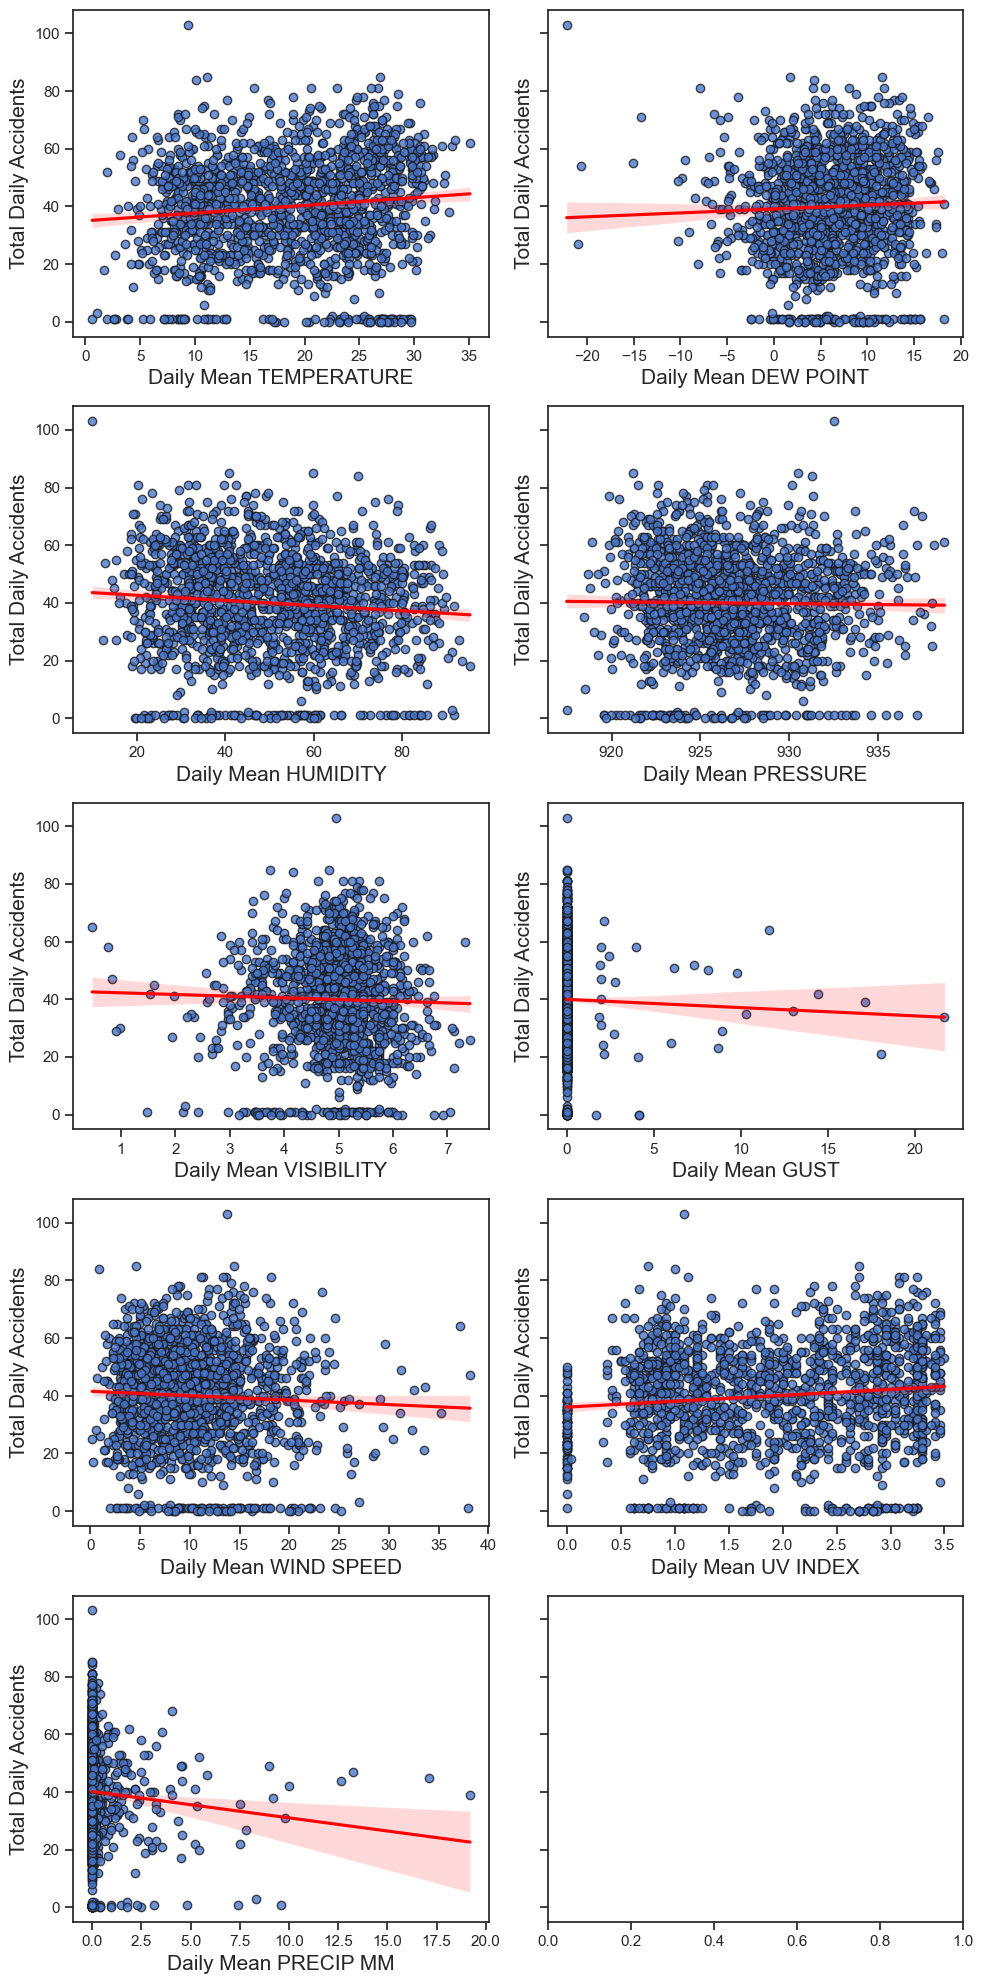

In [132]:
cols = [
    'no_of_accidents', 'temperature', 'dew_point', 'humidity', 'pressure', 'visibility', 'gust', 
    'wind_speed', 'uv_index', 'precip_mm'
]

fig, axes = plt.subplots(5, 2, figsize=(10, 20), sharey=True, tight_layout=True)

for col, ax in zip(cols[1:], axes.flatten()):
    
    sns.regplot(x=col, y='no_of_accidents', data=daily_weather_acc, ax=ax, line_kws={'color' : 'red'}, 
                scatter_kws={'edgecolor' : 'k', 'alpha' : 0.8})
    
    ax.set_ylabel("Total Daily Accidents")
    ax.set_xlabel(f"Daily Mean {col.replace('_', ' ').upper()}");

The above plot shows the relation between total daily number of accidents and the mean weather value. It is obvious that there is no significant linear relationship between any of the variables.

In [133]:
# daily_weather_acc.reset_index().to_csv('daily_weather_acc.csv', index=False)

In [134]:
# df3.to_csv('df3.csv', index=False)

In [135]:
# show_table(
#     weather_acc_hr.asfreq('D')
# )